In [27]:
import pandas as pd
from datetime import datetime, timezone,timedelta,date
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns
from itertools import islice
import json
from web3 import Web3
path = ""
path_output=""

In [2]:
#this is the transfer data we get from on-chain transaction that involved cowswap address
#the data contrains all the token transfer for each transaction
# data origin from EigenPhi
df_all_tx_14=pd.read_csv(path+'cow_14xx.csv.gz',header=None, names
                         =['block','index','tx_hash','from','to','value','transfer_count','input_data','transfers'])

df_all_tx_13=pd.read_csv(path+'cow_139x.csv.gz',header=None, names
                         =['block','index','tx_hash','from','to','value','transfer_count','input_data','transfers'])

df_all_tx_15=pd.read_csv(path+'cow_15xx.csv.gz',header=None, names
                         =['block','index','tx_hash','from','to','value','transfer_count','input_data','transfers'])

df_all_tx_16=pd.read_csv(path+'cow_16xx.csv.gz',header=None, names
                         =['block','index','tx_hash','from','to','value','transfer_count','input_data','transfers'])

In [3]:
#all cowswap transaction data
df_cow_allTrades=pd.concat([df_all_tx_13,
                          df_all_tx_14,
                          df_all_tx_15,
                         df_all_tx_16],ignore_index=True)
df_cow_allTrades['block']=df_cow_allTrades['block'].apply(lambda x: x.split(':')[1])

In [4]:
df_cow_allTrades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284859 entries, 0 to 284858
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   block           284859 non-null  object
 1   index           284859 non-null  int64 
 2   tx_hash         284859 non-null  object
 3   from            284859 non-null  object
 4   to              284859 non-null  object
 5   value           284859 non-null  object
 6   transfer_count  284859 non-null  int64 
 7   input_data      284859 non-null  object
 8   transfers       270927 non-null  object
dtypes: int64(2), object(7)
memory usage: 19.6+ MB


In [ ]:
#merge the datetime onto the all transfer data
df_block_time=pd.read_csv(path+'timestamp-blockNumber_2022.csv')

def binarySearch (arr, l, r, x):  
    if r >= l: 
        mid = int(l + (r - l)/2)
        if arr[mid] <= x and arr[mid+1]>x: 
            return mid    
        elif arr[mid] > x: 
            return binarySearch(arr, l, mid-1, x) 
        else: 
            return binarySearch(arr, mid+1, r, x) 
    else: 
        return -1
def find_timestamp(blockNum):
    if blockNum>=16308190 or blockNum<13916166:
        return None
    listofBlockNum=df_block_time["blockNumber"]
    r=len(df_block_time["blockNumber"])-1
    index=binarySearch (listofBlockNum, 0,r , blockNum)
    if index>=0:
        return df_block_time["timestamp"][index]
    else:
        return "None exist"

timestamp=[]
for i in range(0,len(df_cow_allTrades["block"])):
    timestamp.append(find_timestamp(int(df_cow_allTrades["block"][i])))

df_cow_allTrades['blockTimestamp']=timestamp

df_cow_allTrades=df_cow_allTrades[~df_cow_allTrades['blockTimestamp'].isna()]
df_cow_allTrades['datetime']=df_cow_allTrades['blockTimestamp'].apply(lambda x: datetime.fromtimestamp(x,tz=timezone.utc))
df_cow_allTrades['datetime'] = pd.to_datetime(df_cow_allTrades['datetime']).dt.tz_localize(None)

In [10]:
#get eth price
df_eth_usd=pd.read_csv(path+'eth_usd.csv')
df_eth_usd['datetime']=df_eth_usd['startedAtUnixTimeInSecond'].apply(lambda x: datetime.fromtimestamp(x,tz=timezone.utc))
df_eth_usd['datetime'] = pd.to_datetime(df_eth_usd['datetime']).dt.tz_localize(None)

df_eth_usd[(df_eth_usd['datetime']>='2022-11-09 16:33') & (df_eth_usd['datetime']<'2022-11-10')]

,roundId,answer,startedAtUnixTimeInSecond,updatedAtUnixTimeInSecond,answeredInRound,datetime
36842,36843,1170.426554,1668011615,1668011615,36843,2022-11-09 16:33:35
36843,36844,1162.397245,1668011795,1668011795,36844,2022-11-09 16:36:35
36844,36845,1169.065805,1668011975,1668011975,36845,2022-11-09 16:39:35
36845,36846,1177.250000,1668012095,1668012095,36846,2022-11-09 16:41:35
36846,36847,1192.053950,1668012251,1668012251,36847,2022-11-09 16:44:11
...,...,...,...,...,...,...
36960,36961,1082.390000,1668037127,1668037127,36961,2022-11-09 23:38:47
36961,36962,1091.690000,1668037307,1668037307,36962,2022-11-09 23:41:47
36962,36963,1097.518138,1668037583,1668037583,36963,2022-11-09 23:46:23
36963,36964,1094.730527,1668038147,1668038147,36964,2022-11-09 23:55:47


In [11]:
# Cowswap as victim from sandwich attacks
# data origin from EigenPhi
df_cow_victim=pd.read_csv(path_output+'cowswap_victim_txs.csv')

In [16]:
## Daily observation on sandwich attacks for cowswap
df_cow_victim['datetime']=df_cow_victim['blockTimestamp'].apply(lambda x: datetime.fromtimestamp(x,tz=timezone.utc))
df_cow_victim['datetime'] = pd.to_datetime(df_cow_victim['datetime']).dt.tz_localize(None)
df_cow_victim['date']=df_cow_victim['datetime'].dt.date
df_count_daily=df_cow_victim[['datetime','attackerTxs']].groupby('datetime').count().resample(rule='D').sum()
df_count_daily.sort_values(by='attackerTxs',ascending=False)

,attackerTxs
datetime,
2022-11-09,63
2022-11-10,63
2022-11-22,54
2022-11-14,51
2022-11-16,41
...,...
2022-08-13,0
2022-08-14,0
2022-08-15,0


In [13]:
#cowswap fee revenue
#data origin from dune
df_fee_revenue=pd.read_csv(path+'fee_revenue.csv')

df_fee_revenue=df_fee_revenue[['day','fee_value']]

df_fee_revenue['day']=pd.to_datetime(df_fee_revenue['day'])

df_fee_revenue=df_fee_revenue.set_index('day')

In [14]:
def currency(x, pos):
    """The two args are the value and tick position"""
    if x >= 1e6 or x <= -1e6:
        s = '${:1.1f}M'.format(x*1e-6)
    else:
        s = '${:1.0f}K'.format(x*1e-3)
    return s

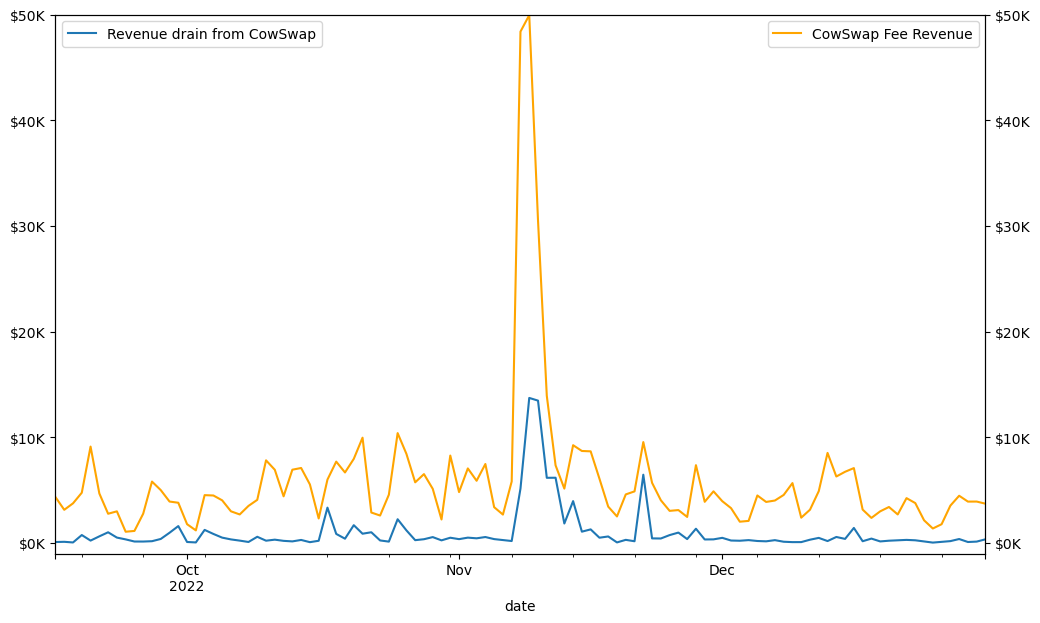

In [17]:
fig, ax1 = plt.subplots(figsize=(12,7))

df_cow_victim.groupby('date').sum()['revenue'].rename('Revenue drain from CowSwap').plot(ax=ax1)
ax1.set_ylim(-1000,50000)
ax1.legend(loc='upper left')
ax2 = ax1.twinx()

df_fee_revenue['fee_value'].rename('CowSwap Fee Revenue')[df_fee_revenue.index>'2022-09-15'].plot(ax=ax2,color='orange')
ax2.set_ylim(-1000,50000)
ax2.legend(loc='upper right')
ax1.yaxis.set_major_formatter(currency)
ax2.yaxis.set_major_formatter(currency)
plt.show()
plt.show()

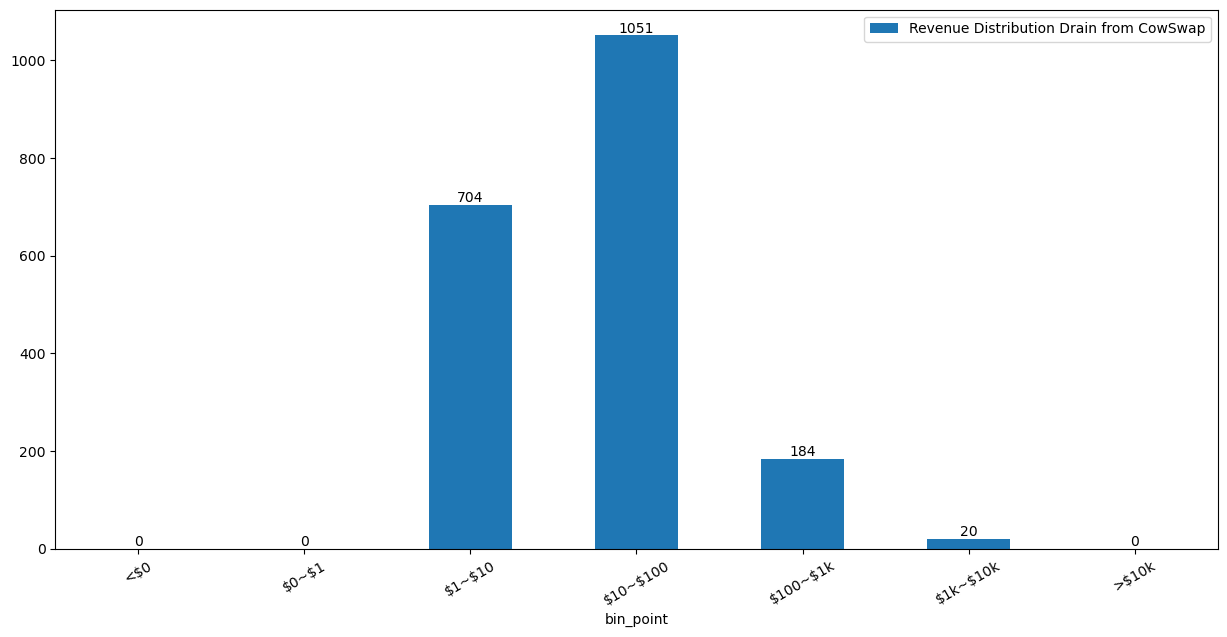

In [18]:
bins_custom = [-10000,0,1, 10, 100, 1000, 10**4,10**8]
bin_point = ['<$0','\$0~\$1','\$1~\$10','\$10~\$100','\$100~\$1k','\$1k~\$10k','>$10k']

count1,bin_edges=np.histogram(df_cow_victim['revenue'], bins=bins_custom, density=False)

hist=pd.DataFrame(count1).rename(columns={0:'Revenue Distribution Drain from CowSwap'})

hist['bin_point'] = bin_point
hist.set_index('bin_point',inplace=True)

fig, axes =plt.subplots(figsize=(15,7))
hist.plot.bar(ax=axes)
for i, v in enumerate(hist['Revenue Distribution Drain from CowSwap']):
    axes.text(i, v+0.1, str(v), ha='center', va='bottom')
#plt.yscale('log')
axes.set_xticklabels(bin_point, rotation = 30)
plt.show()

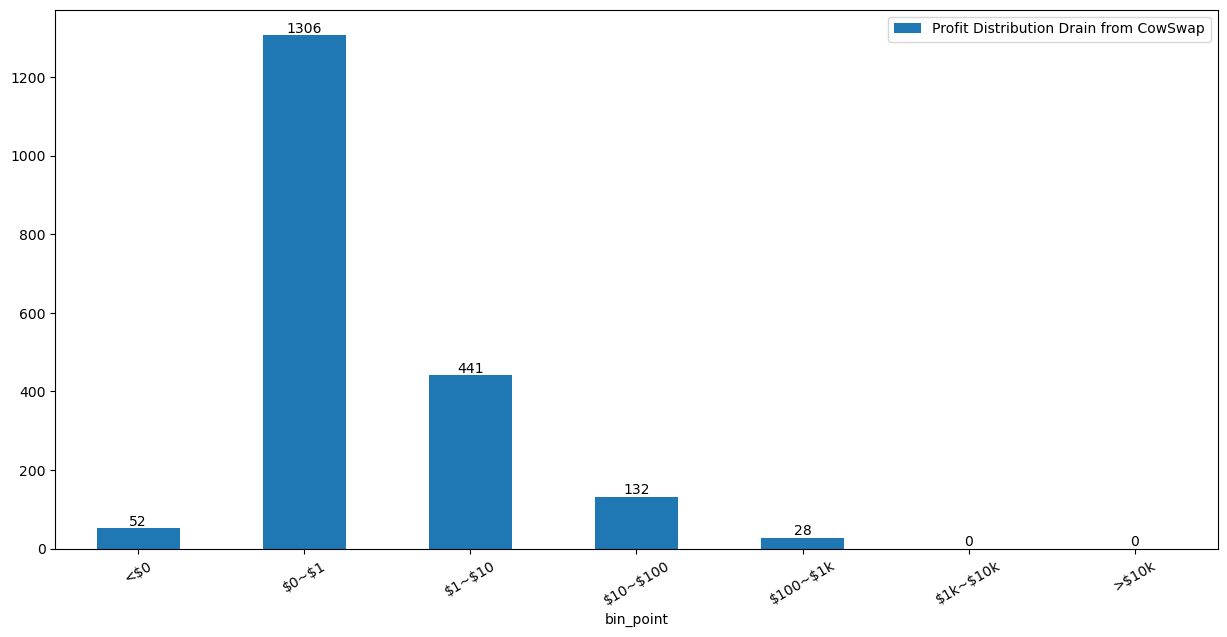

In [19]:
bins_custom = [-10000,0,1, 10, 100, 1000, 10**4,10**8]
bin_point = ['<$0','\$0~\$1','\$1~\$10','\$10~\$100','\$100~\$1k','\$1k~\$10k','>$10k']

count1,bin_edges=np.histogram(df_cow_victim['profit'], bins=bins_custom, density=False)

hist=pd.DataFrame(count1).rename(columns={0:'Profit Distribution Drain from CowSwap'})

hist['bin_point'] = bin_point
hist.set_index('bin_point',inplace=True)

fig, axes =plt.subplots(figsize=(15,7))
hist.plot.bar(ax=axes)
for i, v in enumerate(hist['Profit Distribution Drain from CowSwap']):
    axes.text(i, v+0.1, str(v), ha='center', va='bottom')
#plt.yscale('log')
axes.set_xticklabels(bin_point, rotation = 30)
plt.show()

In [2273]:
df_fee_revenue.sum()

fee_value    8.549145e+06
dtype: float64

In [20]:
df_monthly=df_cow_victim[['datetime','cost','profit']].groupby('datetime').sum().resample(rule='M').sum()[:-1]

In [21]:
df_monthly.index=df_monthly.index.strftime('%B')

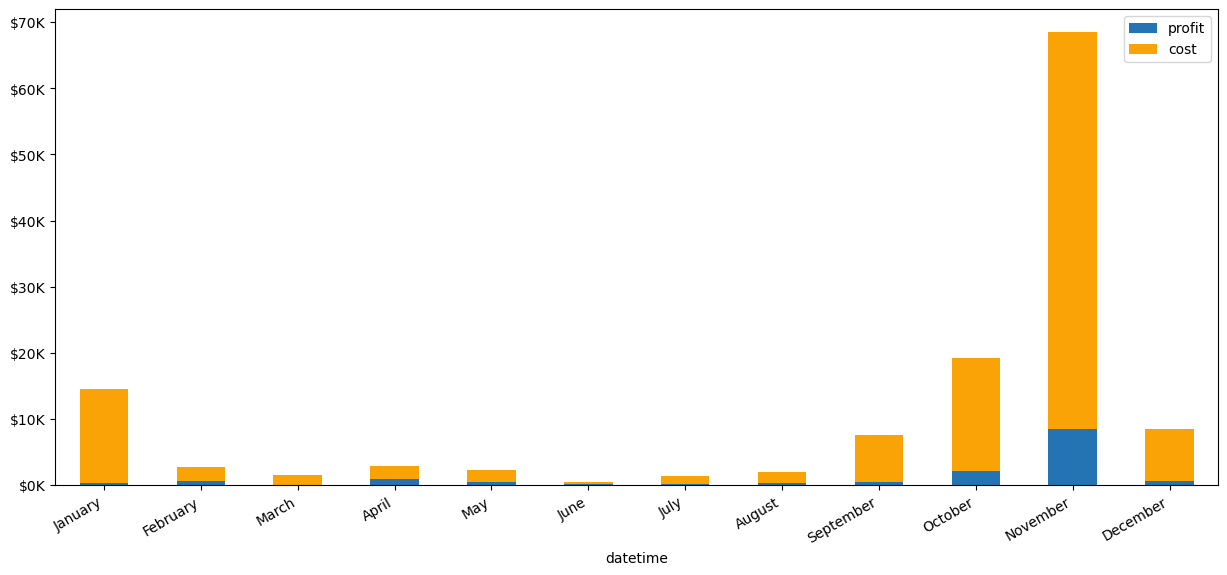

In [23]:
fig, axes =plt.subplots(figsize=(15,7))
df_monthly[['profit','cost']].plot(kind='bar', ax=axes,stacked=True,color=['#2474b4','#faa307'])
#year_month_formatter = mdates.DateFormatter("%b")
#axes.xaxis.set_major_formatter(year_month_formatter)
axes.figure.autofmt_xdate()
axes.yaxis.set_major_formatter(currency)
plt.show()

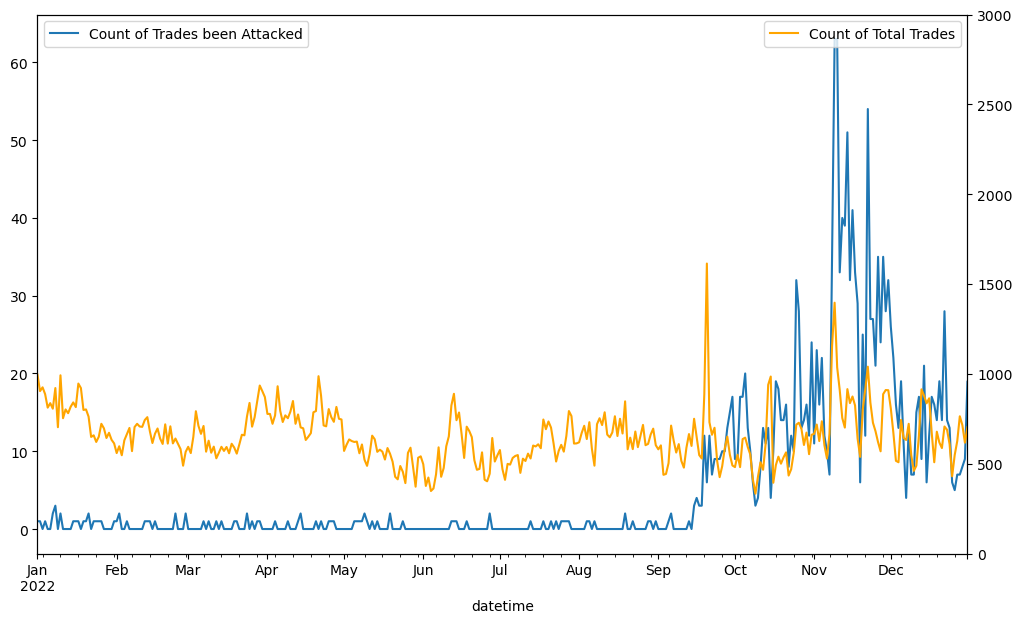

In [24]:
fig, ax1 = plt.subplots(figsize=(12,7))

df_count_daily.rename(columns={'attackerTxs':'Count of Trades been Attacked'}).plot(ax=ax1)
#ax1.set_ylim(-100,100)
ax1.legend(loc='upper left')
ax2 = ax1.twinx()

df_cow_allTrades[['datetime','tx_hash']].groupby('datetime').count().rename(columns={'tx_hash':'Count of Total Trades'}).plot(ax=ax2,color='orange')
ax2.set_ylim(0,3000)
ax2.legend(loc='upper right')
plt.show()

In [25]:
#uniswap and curve sandwich results, the result is from our previous research on the sandwich mev impact on uniswap and curve
#data origin from EigenPhi
df_uniswap=pd.DataFrame([{'row_number':'cowswap','row_value':0.00047},{'row_number':'uniswap','row_value':0.0126}]).set_index('row_number')

df_curve=pd.DataFrame([{'row_number':'cowswap','row_value':0.0014},{'row_number':'uniswap','row_value':0.0041}]).set_index('row_number')

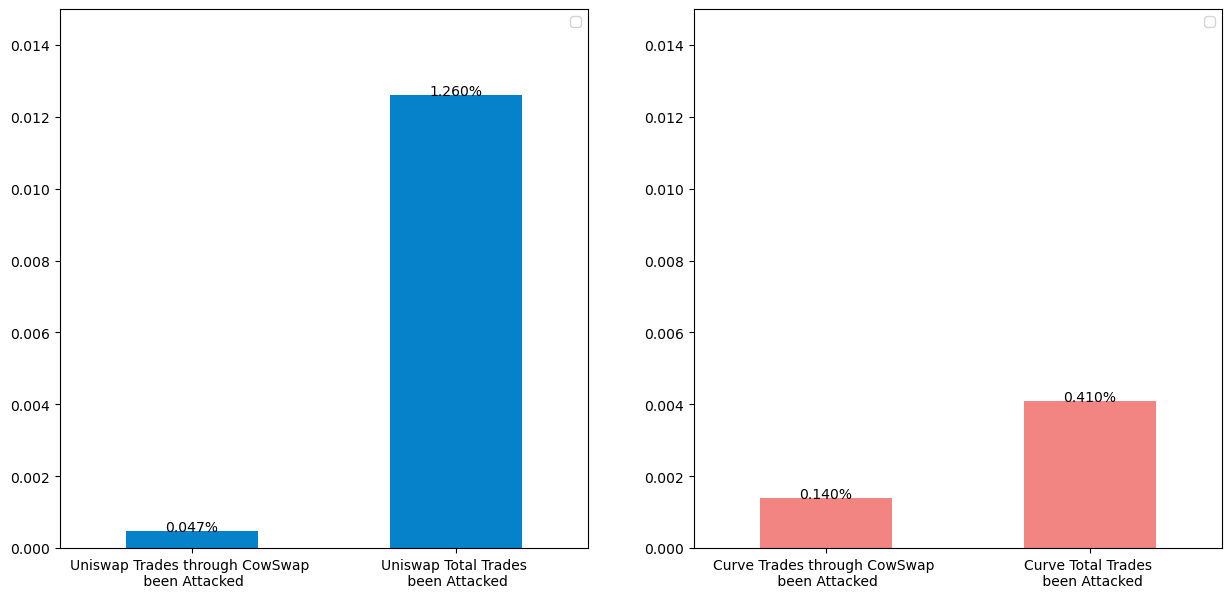

In [28]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
df_uniswap.plot.bar(ax=axes[0],color='#0582ca')
df_curve.plot.bar(ax=axes[1],color='#f28482')
axes[0].set_ylim(0,0.015)
axes[1].set_ylim(0,0.015)
for i, v in enumerate(df_uniswap['row_value']):
    axes[0].text(i, v, '{:.3f}%'.format(df_uniswap['row_value'][i]*100), ha='center')
for i, v in enumerate(df_curve['row_value']):
    axes[1].text(i, v, '{:.3f}%'.format(df_curve['row_value'][i]*100), ha='center')
axes[0].legend('')
axes[0].set_xlabel('')
axes[0].set_xticklabels(['Uniswap Trades through CowSwap \n been Attacked','Uniswap Total Trades \n been Attacked'])
axes[0].tick_params(axis='x',rotation=0)
axes[1].legend('')
axes[1].set_xlabel('')
axes[1].set_xticklabels(['Curve Trades through CowSwap \n been Attacked','Curve Total Trades \n been Attacked'])
axes[1].tick_params(axis='x',rotation=0)
plt.show()

In [29]:
df_cow_victim['attackerTxs'].nunique()

1958

In [30]:
df_cow_allTrades['tx_hash'].nunique()

239379

## The value has been extracted from each solver

In [31]:
#solver information data
#data origin from Dune
df_solver_info=pd.read_csv(path+'solver_info.csv')

In [32]:
group_solver=df_cow_victim[['victimEOAs','revenue']].groupby('victimEOAs').agg({'revenue':['count','sum']}).reset_index()
group_solver.columns = ['_'.join(col).strip() for col in group_solver.columns.values]
group_solver.rename(columns={'victimEOAs_':'victimEOAs'},inplace=True)

In [33]:

# sandwich attackers could attacks multiple victims,
#pick out the mutiple victims that only the cowswap solver got attacked
group_solver.loc[14,'victimEOAs']='0xc9ec550bea1c64d779124b23a26292cc223327b6'

group_solver.loc[18,'victimEOAs']='0xb20b86c4e6deeb432a22d773a221898bbbd03036'

In [35]:
group_solver=group_solver.groupby('victimEOAs').sum().reset_index()

group_solver=group_solver.merge(df_solver_info,left_on='victimEOAs',right_on='Solver',how='left')

group_solver['Trades']=group_solver['Trades'].str.replace(',',"").astype(float)

group_solver['full_name']=group_solver['Name']+'_'+group_solver['victimEOAs'].apply(lambda x: x[:6])

scatter_attacker_victim=df_cow_victim[df_cow_victim['date']>datetime.strptime('2020-09-15', '%Y-%m-%d').date()].groupby(['attackerContract','victimEOAs']).count(
)['attackerTxs' ].reset_index()

/var/folders/6b/m6620wh92lnbqjd1dz1tb0n40000gn/T/ipykernel_65751/1897880685.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x[:5]+'..'+x[-3:] for x in
/var/folders/6b/m6620wh92lnbqjd1dz1tb0n40000gn/T/ipykernel_65751/1897880685.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([y for y in


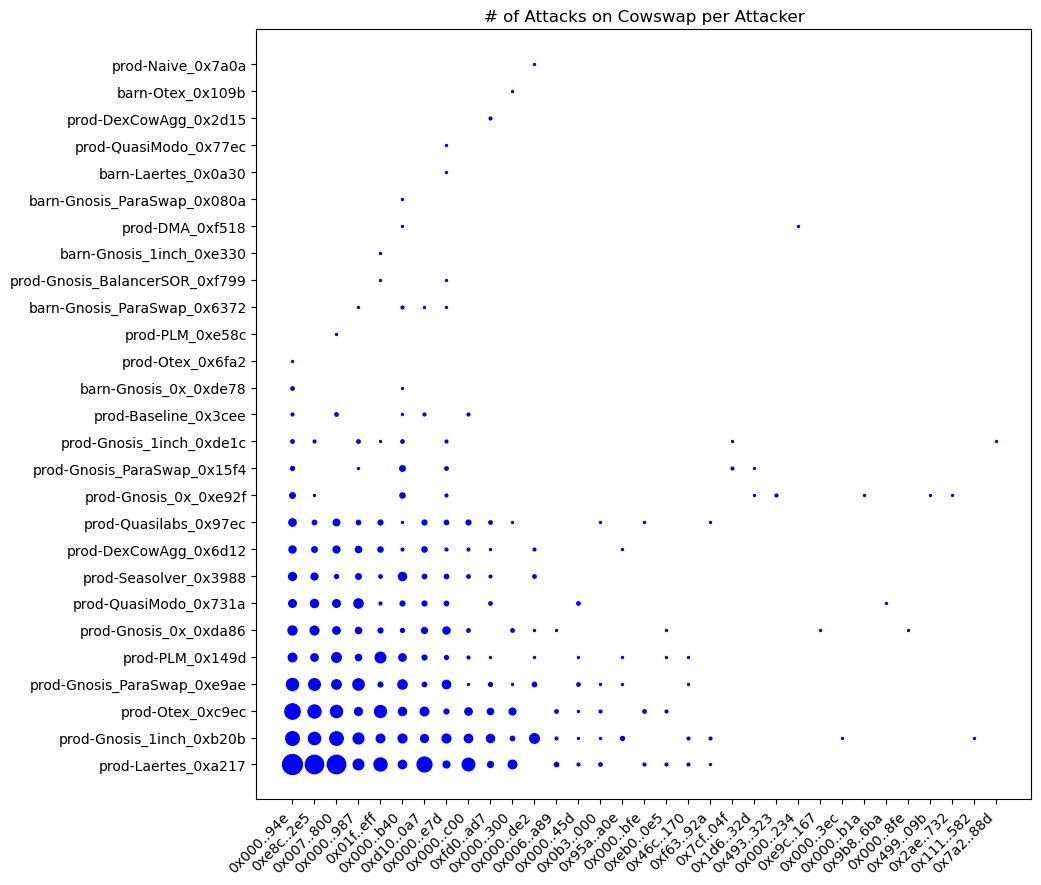

In [41]:
fig, ax=plt.subplots(figsize=(10,10))
for attacker in df_cow_victim.groupby('attackerContract').count()['attackerTxs'].sort_values(ascending=False).index:
    for victim in group_solver.sort_values('revenue_count',ascending=False)['victimEOAs']:
        scatter_plot=scatter_attacker_victim[(scatter_attacker_victim['attackerContract']==attacker)&
                                                       (scatter_attacker_victim['victimEOAs']==victim)]
        ax.scatter(scatter_plot['attackerContract'],scatter_plot['victimEOAs'],s=2*scatter_plot['attackerTxs'],color='blue')
ax.set_title('# of Attacks on Cowswap per Attacker')
#ax.set_xticklabels(new_labels)
ax.set_xticklabels([x[:5]+'..'+x[-3:] for x in 
                   df_cow_victim.groupby('attackerContract').count()['attackerTxs'].sort_values(ascending=False).index
                   ],rotation=45, ha='right')
ax.set_yticklabels([y for y in 
                   group_solver.sort_values('revenue_count',ascending=False)['full_name']
                   ], ha='right')
plt.show()

In [42]:
attacker_scatter=df_cow_victim.groupby(['date','attackerContract']).count(
)['attackerTxs' ].reset_index().sort_values('attackerTxs',ascending=True)

df_attacker_duration=df_cow_victim.groupby('attackerContract').agg({'date':['max','min']})
df_attacker_duration.columns = ['_'.join(col).strip() for col in df_attacker_duration.columns.values]


df_attacker_duration=df_attacker_duration.reset_index()

attacker_scatter=attacker_scatter.merge(df_attacker_duration,on='attackerContract',how='left')

attacker_scatter_group=attacker_scatter.groupby('attackerContract')['attackerTxs'].sum().reset_index().merge(df_attacker_duration,on='attackerContract',how='left')

attacker_scatter_group

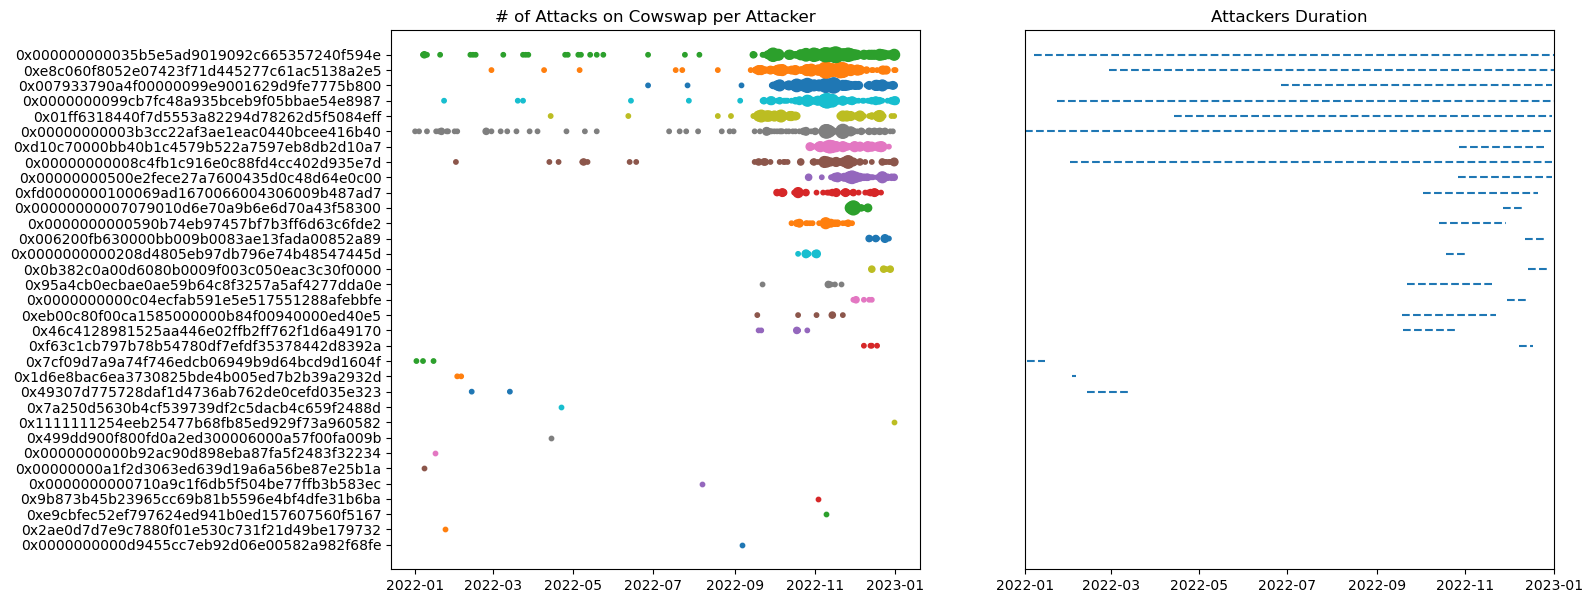

In [49]:
fig, ax=plt.subplots(1,2,figsize=(15,7))
for attacker in df_cow_victim.groupby('attackerContract').count()['attackerTxs'].sort_values().index:
    scatter_attacker=attacker_scatter[attacker_scatter['attackerContract']==attacker]
    ax[0].scatter(scatter_attacker.date,scatter_attacker['attackerContract'],s=10*scatter_attacker['attackerTxs'])
ax[0].set_title('# of Attacks on Cowswap per Attacker')

start_time = date(2022, 1, 1)
end_time= date(2023, 1, 1)
ax[1].set_xlim([start_time, end_time])
ax[1].yaxis.set_ticks([])
ax[1].set_title('Attackers Duration')
for attacker in df_cow_victim.groupby('attackerContract').count()['attackerTxs'].sort_values().index:
    scatter2=attacker_scatter_group[attacker_scatter_group['attackerContract']==attacker]
    ax[1].axhline(y=scatter2['attackerContract'].item(),xmin=(scatter2['date_min'].item()-start_time).total_seconds()/(end_time-start_time).total_seconds()
               ,xmax=(scatter2['date_max'].item()-start_time).total_seconds()/(end_time-start_time).total_seconds(),linestyle='--')

In [52]:
df_attacker_analysis=df_cow_victim.groupby('attackerContract').agg({'datetime':['max','min'],'attackerTxs':'count'})
df_attacker_analysis.columns = ['_'.join(col).strip() for col in df_attacker_analysis.columns.values]
df_attacker_analysis[df_attacker_analysis['datetime_min']>'2022-09-15'].count()

datetime_max         16
datetime_min         16
attackerTxs_count    16
dtype: int64

In [53]:
df_attacker_analysis.sort_values('attackerTxs_count',ascending=False)

,datetime_max,datetime_min,attackerTxs_count
attackerContract,,,
0x000000000035b5e5ad9019092c665357240f594e,2023-01-01 03:57:59,2022-01-07 04:43:51,368
0xe8c060f8052e07423f71d445277c61ac5138a2e5,2023-01-01 05:39:35,2022-02-28 12:29:29,286
0x007933790a4f00000099e9001629d9fe7775b800,2022-12-31 22:01:47,2022-06-27 19:08:22,281
0x0000000099cb7fc48a935bceb9f05bbae54e8987,2023-01-01 13:52:35,2022-01-23 20:07:34,178
0x01ff6318440f7d5553a82294d78262d5f5084eff,2022-12-31 14:32:11,2022-04-14 13:12:09,162
0x00000000003b3cc22af3ae1eac0440bcee416b40,2022-12-30 01:24:47,2022-01-01 11:37:05,145
0xd10c70000bb40b1c4579b522a7597eb8db2d10a7,2022-12-27 20:38:23,2022-10-28 07:38:11,139
0x00000000008c4fb1c916e0c88fd4cc402d935e7d,2022-12-31 23:11:23,2022-02-01 06:10:04,101
0x00000000500e2fece27a7600435d0c48d64e0c00,2022-12-31 17:09:47,2022-10-27 05:15:59,92


In [57]:
scatter=df_cow_victim.groupby(['date','victimEOAs']).count()['attackerTxs'].reset_index()

In [58]:
scatter.sort_values('attackerTxs')

,date,victimEOAs,attackerTxs
0,2022-01-01,0x15f4c337122ec23859ec73bec00ab38445e45304,1
582,2022-12-08,0x398890be7c4fac5d766e1aeffde44b2ee99f38ef,1
233,2022-10-16,0xa21740833858985e4d801533a808786d3647fb83,1
231,2022-10-16,0x149d0f9282333681ee41d30589824b2798e9fb47,1
586,2022-12-08,0xc9ec550bea1c64d779124b23a26292cc223327b6,1
...,...,...,...
397,2022-11-10,0xb20b86c4e6deeb432a22d773a221898bbbd03036,15
392,2022-11-09,0xe9ae2d792f981c53ea7f6493a17abf5b2a45a86b,15
460,2022-11-18,0xa21740833858985e4d801533a808786d3647fb83,16
526,2022-11-28,0xa21740833858985e4d801533a808786d3647fb83,18


In [59]:
group_solver['full_name']=group_solver['Name']+'_'+group_solver['victimEOAs'].apply(lambda x: x[:6])

scatter=scatter.merge(group_solver[['victimEOAs','full_name']],on='victimEOAs',how='left')

group_solver['Solver'].nunique()

sort_solvers=group_solver.sort_values('revenue_count',ascending=True)

In [67]:
start_time = datetime(2022, 1, 1, 0, 0)
end_time = datetime(2022, 12, 31, 0, 0)

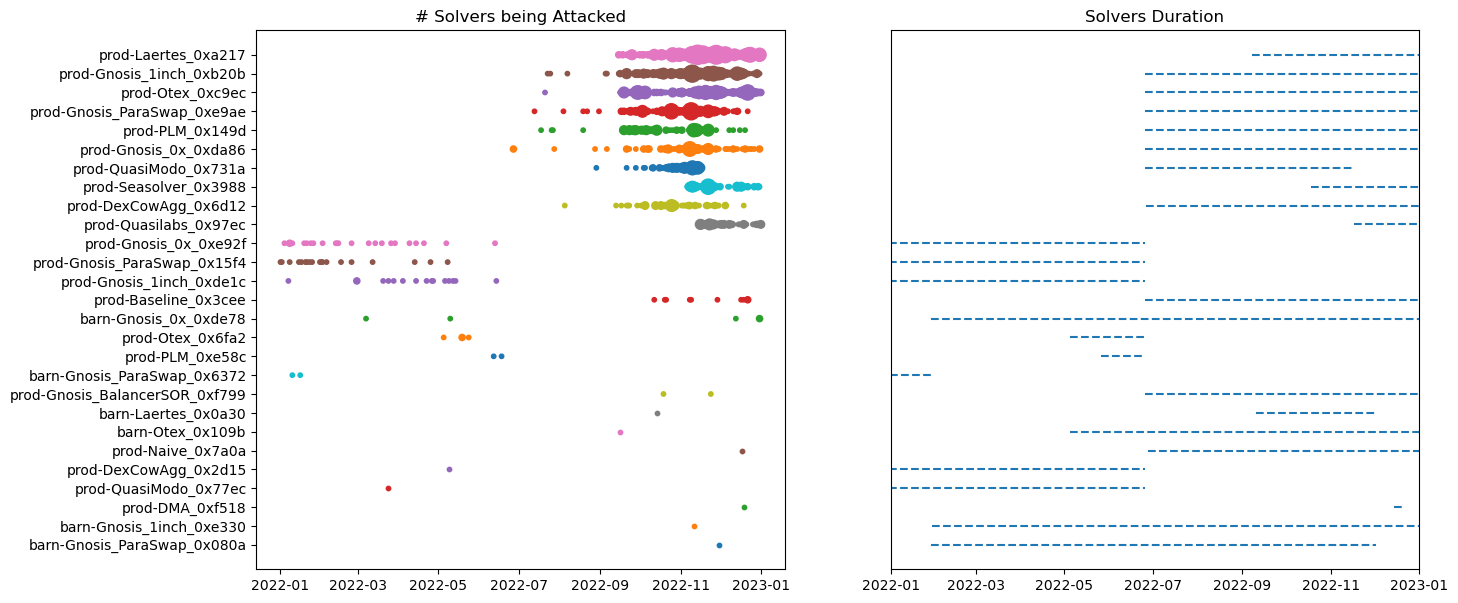

In [68]:
fig, ax=plt.subplots(1,2,figsize=(15,7))
for victimEOAs in group_solver.sort_values('revenue_count',ascending=True)['victimEOAs']:
    scatter_victim=scatter[scatter['victimEOAs']==victimEOAs]
    ax[0].scatter(scatter_victim.date,scatter_victim['full_name'],s=10*scatter_victim['attackerTxs'])
ax[0].set_title('# Solvers being Attacked')
year_start = datetime(2022, 1, 1)
year_end = datetime(2023, 1, 1)
ax[1].set_xlim([year_start, year_end])
ax[1].yaxis.set_ticks([])
ax[1].set_title('Solvers Duration')
for victimEOAs in group_solver.sort_values('revenue_count',ascending=True)['victimEOAs']:
    scatter2=sort_solvers[sort_solvers['victimEOAs']==victimEOAs]
    ax[1].axhline(y=scatter2['full_name'].item(),xmin=(datetime.strptime(scatter2['First Eligible Batch'].item(),'%Y-%m-%d %H:%M')-start_time).total_seconds()/(end_time-start_time).total_seconds()
               ,xmax=(datetime.strptime(scatter2['Latest Batch'].item(),'%Y-%m-%d %H:%M')-start_time).total_seconds()/(end_time-start_time).total_seconds(),linestyle='--')


## top 10 active solvers and the attacks 

In [69]:
plot_top10_solver_total=group_solver.sort_values('Trades',ascending=False).head(10)[['victimEOAs','Name','Trades','revenue_count']]

plot_top10_solver_total=plot_top10_solver_total.sort_values('Trades').reset_index()

plot_top10_solver_total['attackedPct']=plot_top10_solver_total['revenue_count']/plot_top10_solver_total['Trades']

plot_top10_solver_total['victimEOAs']=plot_top10_solver_total['Name']+'_'+plot_top10_solver_total['victimEOAs']

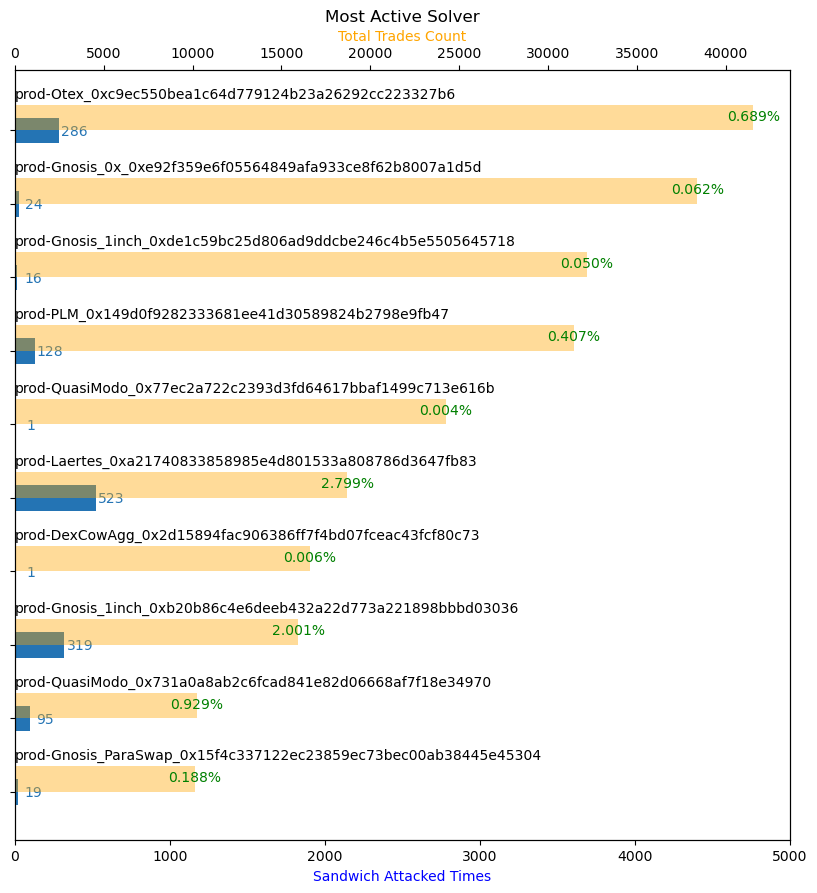

In [73]:

fig, ax1 = plt.subplots(figsize=(10,10))

bars=ax1.barh(plot_top10_solver_total['victimEOAs'],plot_top10_solver_total['revenue_count'],
         height=0.35,color='#2474b4')
ax1.set_xlabel('Sandwich Attacked Times',color='blue')
ax1.set_title('Most Active Solver')
for i, bar in enumerate(bars):
    ax1.text(1, i+0.5, str(pd.Categorical(plot_top10_solver_total['victimEOAs'])[i]), ha='left', va='center')
ax1.set_yticklabels([])
ax1.set_xlim(0,5000)

ax2 = ax1.twiny()
bars2=ax2.barh(plot_top10_solver_total['victimEOAs'],plot_top10_solver_total['Trades'],alpha=0.4,height=0.35,align='edge',color='orange')
ax2.set_xlabel('Total Trades Count',color='orange')


for i, v in enumerate(bars2):
    ax2.text(plot_top10_solver_total['Trades'][i]+10, i+0.1, str("{:.3f}".format(plot_top10_solver_total['attackedPct'][i] * 100))+'%', ha='center', va='bottom',color='green')
    
for i, v in enumerate(bars2):
    ax1.text(plot_top10_solver_total['revenue_count'][i]+100, i-0.1, str(plot_top10_solver_total['revenue_count'][i]), ha='center', va='bottom',color='#2474b4')



# Seperate the attacker and victim volume

In [74]:
df_all_transfer=df_cow_allTrades['transfers'].astype('string').fillna('').apply(lambda x: x.split('|')).explode().reset_index()

df_all_transfer[['token','transfer_from','transfer_to','amount']]=df_all_transfer['transfers'].str.split(';', expand=True)

df_all_transfer[['tx_hash','from','to']]=df_cow_allTrades.loc[df_all_transfer['index']].reset_index()[['tx_hash','from','to']]
#protocol label 
#data from EigenPhi
df_protocol=pd.read_csv(path+'protocol_bigquery.csv')

df_all_transfer=df_all_transfer.merge(df_protocol[['name','address']],left_on='transfer_from',right_on='address',how='left').rename(columns={'name':'transfer_from_protocol'})

df_all_transfer=df_all_transfer.merge(df_protocol[['name','address']],left_on='transfer_to',right_on='address',how='left').rename(columns={'name':'transfer_to_protocol'})

## first get the price of the tokens in each sandwich txs

In [80]:
#token price data for each sandwich group
#data from EigenPhi
df_token_price=pd.read_csv(path+'ethereum_Tagged_Transaction_sandwich_tokenPriceList_13907609_16312971.csv')

df_token_price=pd.concat([df_token_price,pd.json_normalize(df_token_price['tokenPriceList'].apply(json.loads))],axis=1)

#df_token_price.drop(['tokenPriceList','timestamp.$numberLong'],axis=1,inplace=True)

df_token_price.rename(columns={'_id':'transactionHash'},inplace=True)

df_cow_victim=df_cow_victim.merge(df_token_price,on='transactionHash',how='left')

df_cow_volume_seperate=df_cow_victim[df_cow_victim['tokenPrices'].apply(lambda x: type(x)!=float)]

df_cow_volume_price=df_cow_volume_seperate[['transactionHash','tokenPrices']].explode('tokenPrices')

df_cow_volume_price[['token','price']]=df_cow_volume_price['tokenPrices'].apply(lambda x: pd.Series(x))

## next merge the price to the victim's transfer to calculate the volume
### 1: filter out the victim's transfers
### 2: find the transfer that related to common lps
### 3: calculate the volume that the victim put in the common lps


In [83]:
# For cases that contains multiple victims, pick out the ones that is cowswap
# 0x06f204e1c5d1e6a252fe76c8f63ac048c9402fcee9b72a58e112637d50cb81d8
# 0x6a5aa9943ad07279e9b3fdbe2f5e961097ada26ad3c5b33ef2a9b70bb2841233

df_cow_victim.drop(1873,inplace=True)


df_cow_victim[df_cow_victim['attackerTxs']=='0x96e0e0f5fb64b7f4550c2155fcb78e27079931efb2f37150e87320e71b98ca0e 0xbde288b173ed3c6cdae009894bb5260a4e686789227f16d5f6d2cd112b298116']


,Unnamed: 0,index,blockNumber,blockTimestamp,attackerTxs,attackerTxPositions,victimTxs,victimTxPositions,attackerEOA,attackerContract,...,profitNum,volume,volumeNum,lps,transactionHash,datetime,date,tokenPriceList,tokenPrices,timestamp.$numberLong
1872,1872,578302,16247797,1671803039,0x96e0e0f5fb64b7f4550c2155fcb78e27079931efb2f3...,0 3,0x6a5aa9943ad07279e9b3fdbe2f5e961097ada26ad3c5...,1 2,0xc7bf1bf8d639db5ae9c52c905747795752dc967a,0xe8c060f8052e07423f71d445277c61ac5138a2e5,...,2.0528,36469.985241,36469.9852,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0xa2d96d3a010c7f1c7d112d0f470a50bc1cf6af29bc38...,2022-12-23 13:43:59,2022-12-23,NaN,NaN,NaN


In [84]:
#explore whether there are multiple victims
df_cow_victim[df_cow_victim['victimTxs'].apply(lambda x: x.rstrip().split(' ')).apply(
    lambda x: len(x))>1]

,Unnamed: 0,index,blockNumber,blockTimestamp,attackerTxs,attackerTxPositions,victimTxs,victimTxPositions,attackerEOA,attackerContract,...,profitNum,volume,volumeNum,lps,transactionHash,datetime,date,tokenPriceList,tokenPrices,timestamp.$numberLong
1705,1705,547001,16170840,1670874875,0x42f8f47482dbc90125526d51ef1c7a0ab79fd09e6cf9...,7 11,0x86c158683a6739ab84ae8c9904bf690b6da7163fe8ae...,8 9 10,0x99c60fe146534559fa9d1f6a081f4e6675f5f846,0x007933790a4f00000099e9001629d9fe7775b800,...,0.1678,42925.906467,42925.9065,0x088ee5007c98a9677165d78dd2109ae4a3d04d0c,0x44f7f2b12a4052b8380f67c9aef7d158862ecbb879ff...,2022-12-12 19:54:35,2022-12-12,"{""timestamp"":{""$numberLong"":""1670874875""},""tok...",[{'address': '0xc02aaa39b223fe8d0a0e5c4f27ead9...,1670874875
1872,1872,578302,16247797,1671803039,0x96e0e0f5fb64b7f4550c2155fcb78e27079931efb2f3...,0 3,0x6a5aa9943ad07279e9b3fdbe2f5e961097ada26ad3c5...,1 2,0xc7bf1bf8d639db5ae9c52c905747795752dc967a,0xe8c060f8052e07423f71d445277c61ac5138a2e5,...,2.0528,36469.985241,36469.9852,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0xa2d96d3a010c7f1c7d112d0f470a50bc1cf6af29bc38...,2022-12-23 13:43:59,2022-12-23,NaN,NaN,NaN


In [85]:
df_cow_victim['victimTxs'][1705]='0x06f204e1c5d1e6a252fe76c8f63ac048c9402fcee9b72a58e112637d50cb81d8'
df_cow_victim['victimTxs'][1872]='0x6a5aa9943ad07279e9b3fdbe2f5e961097ada26ad3c5b33ef2a9b70bb2841233'

/var/folders/6b/m6620wh92lnbqjd1dz1tb0n40000gn/T/ipykernel_65751/4146643124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cow_victim['victimTxs'][1705]='0x06f204e1c5d1e6a252fe76c8f63ac048c9402fcee9b72a58e112637d50cb81d8'
/var/folders/6b/m6620wh92lnbqjd1dz1tb0n40000gn/T/ipykernel_65751/4146643124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cow_victim['victimTxs'][1872]='0x6a5aa9943ad07279e9b3fdbe2f5e961097ada26ad3c5b33ef2a9b70bb2841233'


In [86]:
df_cow_victim['victimTxs']=df_cow_victim['victimTxs'].apply(lambda x: x.rstrip())

### 1: filter out the victim's transfers

In [89]:
#cowswap victim tx list
#data from EigenPhi
df_cow_sandwich_tx=pd.read_csv(path_output+'cowswap_victim_txlist.csv')

df_victim_transfer=df_all_transfer[df_all_transfer['tx_hash'].isin(df_cow_sandwich_tx['txHash'])]

### 2: find the transfer that related to common lps

In [92]:
df_merge_1=df_cow_victim[['transactionHash','victimTxs','lps']].merge(
    df_victim_transfer[['tx_hash','transfer_from','transfer_to','token','amount']],left_on='victimTxs',
    right_on='tx_hash',how='left')
df_merge_1.head()

,transactionHash,victimTxs,lps,tx_hash,transfer_from,transfer_to,token,amount
0,0x61c08ccafc2ef4dacee7dfb38034dc30c97cec11247b...,0x07e48b8d4bc472e457432f7db25e7292723daa4548aa...,0x97524f602706cdb64f9dfa71909ace06e98200b6,0x07e48b8d4bc472e457432f7db25e7292723daa4548aa...,0x670647441d9c24d981923c9293a2e4eae6d0c8b3,0x9008d19f58aabd9ed0d60971565aa8510560ab41,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,19000000000000000000
1,0x61c08ccafc2ef4dacee7dfb38034dc30c97cec11247b...,0x07e48b8d4bc472e457432f7db25e7292723daa4548aa...,0x97524f602706cdb64f9dfa71909ace06e98200b6,0x07e48b8d4bc472e457432f7db25e7292723daa4548aa...,0x663694857eb8a7432559f5c099a20bac59287d3a,0x9008d19f58aabd9ed0d60971565aa8510560ab41,0x4b520c812e8430659fc9f12f6d0c39026c83588d,23516565599500000000000
2,0x61c08ccafc2ef4dacee7dfb38034dc30c97cec11247b...,0x07e48b8d4bc472e457432f7db25e7292723daa4548aa...,0x97524f602706cdb64f9dfa71909ace06e98200b6,0x07e48b8d4bc472e457432f7db25e7292723daa4548aa...,0x9008d19f58aabd9ed0d60971565aa8510560ab41,0xdef171fe48cf0115b1d80b88dc8eab59176fee57,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,18966228906189153984
3,0x61c08ccafc2ef4dacee7dfb38034dc30c97cec11247b...,0x07e48b8d4bc472e457432f7db25e7292723daa4548aa...,0x97524f602706cdb64f9dfa71909ace06e98200b6,0x07e48b8d4bc472e457432f7db25e7292723daa4548aa...,0xdef171fe48cf0115b1d80b88dc8eab59176fee57,0x97524f602706cdb64f9dfa71909ace06e98200b6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,385014446795639825
4,0x61c08ccafc2ef4dacee7dfb38034dc30c97cec11247b...,0x07e48b8d4bc472e457432f7db25e7292723daa4548aa...,0x97524f602706cdb64f9dfa71909ace06e98200b6,0x07e48b8d4bc472e457432f7db25e7292723daa4548aa...,0x97524f602706cdb64f9dfa71909ace06e98200b6,0xdef171fe48cf0115b1d80b88dc8eab59176fee57,0x3472a5a71965499acd81997a54bba8d852c6e53d,83547607285718894470


In [94]:
#explode the lps
df_merge_1['lps']=df_merge_1['lps'].apply(lambda x: x.split(' '))

df_merge_1=df_merge_1.explode('lps')

df_victim_volume=df_merge_1[
    (df_merge_1['lps']==df_merge_1['transfer_from']) | (df_merge_1['lps']==df_merge_1['transfer_to'])]

### next merge the price to the table

#add decimals to amount
#data from EigenPhi
df_token_decimals=pd.read_csv(path+'token_decimals.csv')

df_token_decimals=df_token_decimals[['address','decimals']].groupby('address').agg({'decimals':'max'}).reset_index()

In [99]:
#calculate the victim volume
df_victim_volume=df_victim_volume.merge(
    df_token_decimals[['address','decimals']],left_on='token',right_on='address',how='left')

df_victim_volume=df_victim_volume.merge(df_cow_volume_price,on='transactionHash',how='left')

df_victim_volume=df_victim_volume[df_victim_volume['token_x']==df_victim_volume['token_y']].reset_index()

df_victim_volume['amount']=df_victim_volume['amount'].astype(float)*df_victim_volume['decimals'].apply(lambda x: 10**(-x))

df_victim_volume['price']=df_victim_volume['price'].astype(float)


df_victim_volume['V_volume']=df_victim_volume['price']*df_victim_volume['amount']

def select_value(group):
    if '0xdac17f958d2ee523a2206206994597c13d831ec7' in group['token_y'].values:
        return group.loc[group['token_y'] == '0xdac17f958d2ee523a2206206994597c13d831ec7','V_volume'].values[0]
    elif '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2' in group['token_y'].values:
        return group.loc[group['token_y'] == '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2']['V_volume'].values[0]
    elif '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48' in group['token_y'].values:
        return group.loc[group['token_y'] == '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48']['V_volume'].values[0]
    elif '0x6b175474e89094c44da98b954eedeac495271d0f' in group['token_y'].values:
        return group.loc[group['token_y'] == '0x6b175474e89094c44da98b954eedeac495271d0f']['V_volume'].values[0] 
    elif '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599' in group['token_y'].values:
        return group.loc[group['token_y'] == '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599']['V_volume'].values[0] 
    else:
        return group['V_volume'].max()

df_victim_volume_final=df_victim_volume.groupby(
    ['transactionHash','victimTxs']).apply(select_value).reset_index()

df_victim_volume_final.rename(columns={0:'V_volume'},inplace=True)

In [107]:
df_victim_volume_final[0].sum()

100095406.30044651

## investigation on the protocols volume

In [118]:
df_victim_volume_final=df_victim_volume_final.merge(df_cow_victim[['transactionHash','lps']],on='transactionHash',how='left')

df_victim_volume_final.groupby('lps').count().sort_values('transactionHash',ascending=False).head(20).reset_index().merge(
df_protocol[['address','name']],left_on='lps',right_on='address')

lp_group=df_victim_volume_final.groupby('lps').agg({'victimTxs':'count','V_volume':'sum'}).reset_index().merge(
df_protocol[['address','name']],left_on='lps',right_on='address')

lp_plot=lp_group.groupby('name').sum('victimTxs').sort_values('victimTxs')

lp_plot

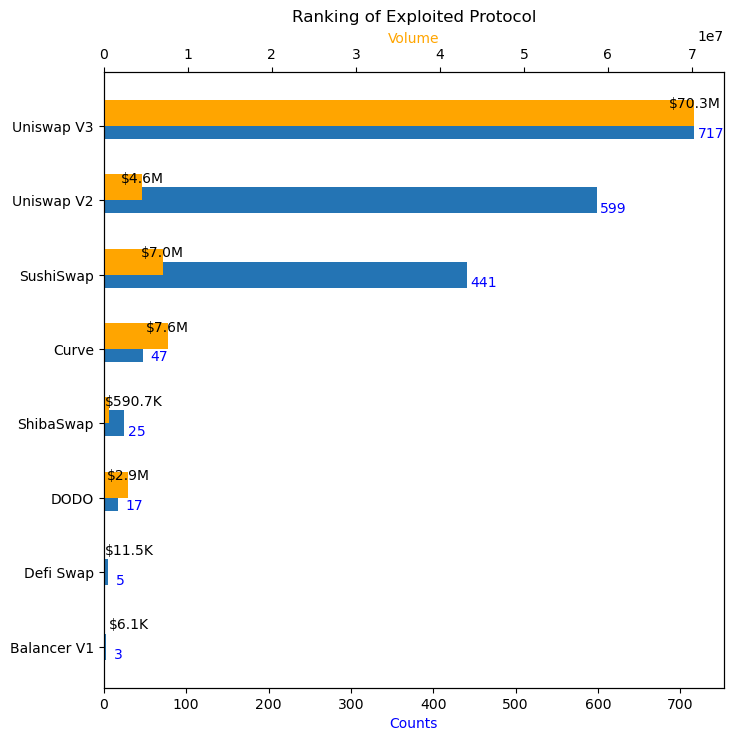

In [121]:
fig, ax1 = plt.subplots(figsize=(8,8))

bars=ax1.barh(lp_plot.index,lp_plot['victimTxs'],
         height=0.35,color='#2474b4')
ax1.set_xlabel('Counts',color='blue')
ax1.set_title('Ranking of Exploited Protocol')
#ax1.set_yticklabels([])
#ax1.set_xlim(0,800)

ax2 = ax1.twiny()
bars2=ax2.barh(lp_plot.index,lp_plot['V_volume'],height=0.35,align='edge',color='orange')
ax2.set_xlabel('Volume',color='orange')


for i, v in enumerate(bars2):
    if i in [2,4,5,6,7]:
        ax2.text(lp_plot['V_volume'][i], i+0.2, str('$%1.1fM' % (lp_plot['V_volume'][i] * 1e-6)), ha='center', va='bottom')
    else:
        ax2.text(lp_plot['V_volume'][i]+3e6, i+0.2, str('$%1.1fK' % (lp_plot['V_volume'][i] * 1e-3)), ha='center', va='bottom')

for i, v in enumerate(bars):
    if i in [2,4,5,6,7]:
        ax1.text(lp_plot['victimTxs'][i]+20, i-0.2, str(lp_plot['victimTxs'][i]), ha='center', va='bottom',color='blue')
    else:
        ax1.text(lp_plot['victimTxs'][i]+15, i-0.2, str(lp_plot['victimTxs'][i]), ha='center', va='bottom',color='blue')



In [122]:
lp_plot_pool=df_victim_volume_final.groupby('lps').agg({'victimTxs':'count','V_volume':'sum'}).reset_index().merge(
df_protocol[['address','name']],left_on='lps',right_on='address')


lp_plot_pool=lp_plot_pool.sort_values('victimTxs',ascending=False).head(10)
lp_plot_pool['pool_name']=lp_plot_pool['name']+'_'+lp_plot_pool['lps']

lp_plot_pool=lp_plot_pool.sort_values('victimTxs').set_index('pool_name')

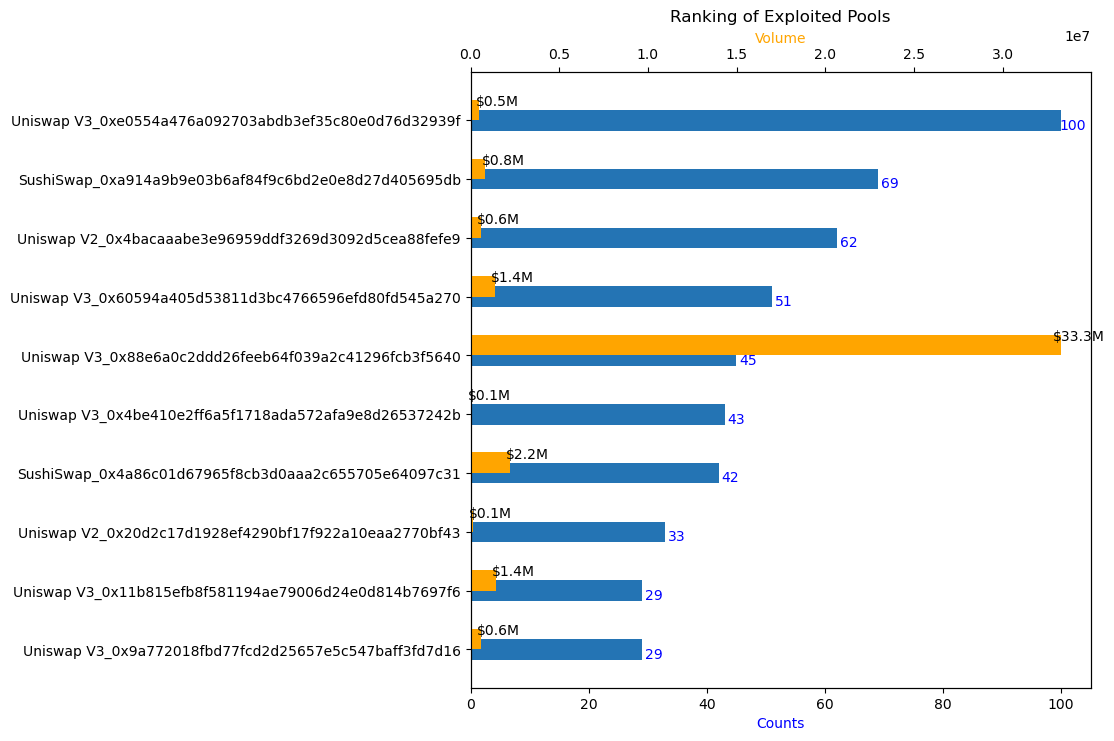

In [125]:
fig, ax1 = plt.subplots(figsize=(8,8))

bars=ax1.barh(lp_plot_pool.index,lp_plot_pool['victimTxs'],
         height=0.35,color='#2474b4')
ax1.set_xlabel('Counts',color='blue')
ax1.set_title('Ranking of Exploited Pools')
#ax1.set_yticklabels([])
#ax1.set_xlim(0,800)

ax2 = ax1.twiny()
bars2=ax2.barh(lp_plot_pool.index,lp_plot_pool['V_volume'], height=0.35,align='edge',color='orange')
ax2.set_xlabel('Volume',color='orange')


for i, v in enumerate(bars2):
    ax2.text(lp_plot_pool['V_volume'][i]+1e6, i+0.2, str('$%1.1fM' % (lp_plot_pool['V_volume'][i] * 1e-6)), ha='center', va='bottom')
    
for i, v in enumerate(bars):
    ax1.text(lp_plot_pool['victimTxs'][i]+2, i-0.2, str(lp_plot_pool['victimTxs'][i]), ha='center', va='bottom',color='blue')
    

In [126]:
protocol_all_trades=pd.DataFrame(df_all_transfer.groupby('transfer_from_protocol').count()['tx_hash'].sort_values())

protocol_all_trades=protocol_all_trades.merge(lp_plot,left_index=True, right_index=True,how='left'
                                             ).sort_values('tx_hash',ascending=False)

protocol_all_trades=protocol_all_trades.fillna(0).rename(columns={'tx_hash':'# of Total Trades','victimTxs':'# of attacked Trades',
                                              'V_volume':'Attacked Volume'})

protocol_all_trades['Attacked Pct']=protocol_all_trades['# of attacked Trades']/protocol_all_trades['# of Total Trades']

In [139]:
protocol_all_trades.iloc[:-1].rename_axis('Protocol').style.apply(lambda x: ['background: lightyellow' if x.name in ['Bancor','KyberSwap', 'Clipper',
       'Uniswap V1', '1inch Network', 'Saddle Finance', 'SakePerp', 'Frax',
       'CREAM Finance', 'MooniSwap', 'Convergence', 'Swerve', 'PowerPool'] 
                              else '' for i in x], 
                   axis=1).format({'Attacked Pct': '{:.2%}'})

,# of Total Trades,# of attacked Trades,Attacked Volume,Attacked Pct
Protocol,,,,
Uniswap V3,195688,717.000000,70283604.950111,0.37%
Uniswap V2,85841,599.000000,4589778.555757,0.70%
SushiSwap,59214,441.000000,6984964.646782,0.74%
Curve,32774,47.000000,7594930.644417,0.14%
Balancer V1,6770,3.000000,6121.049728,0.04%
DODO,5675,17.000000,2882596.620878,0.30%
Bancor,4801,0.000000,0.000000,0.00%
Defi Swap,3214,5.000000,11493.212596,0.16%
ShibaSwap,2440,25.000000,590701.816764,1.02%


## filter out the attacker volume

In [1309]:
# find out all the attackers tx

In [189]:
df_cow_victim['attackerTxslist']=df_cow_victim['attackerTxs'].apply(lambda x: x.split(' '))

df_attacker_volume=df_cow_victim[['attackerTxslist','transactionHash','lps']].explode('attackerTxslist')
df_attacker_volume.rename(columns={'attackerTxslist':'tx_hash'},inplace=True)

# merge on all transfers

df_attacker_Txs=pd.read_csv(path+'attacker_allTxs.csv',header=None, names
                         =['block','index','tx_hash','from','to','value','transfer_count','input_data','transfers'])

df_attacker_transfer=df_attacker_Txs['transfers'].astype('string').fillna('').apply(lambda x: x.split('|')).explode().reset_index()

df_attacker_transfer[['token','transfer_from','transfer_to','amount']]=df_attacker_transfer['transfers'].str.split(';', expand=True)

df_attacker_transfer[['tx_hash','from','to']]=df_attacker_Txs.loc[
    df_attacker_transfer['index']].reset_index()[['tx_hash','from','to']]

df_attacker_volume=df_attacker_volume.merge(df_attacker_transfer,on='tx_hash',how='left')

df_attacker_volume['lps']=df_attacker_volume['lps'].apply(lambda x: x.split(' '))

df_attacker_volume=df_attacker_volume.explode('lps')

df_attacker_volume=df_attacker_volume[
    (df_attacker_volume['lps']==df_attacker_volume['transfer_from']) | (df_attacker_volume['lps']==df_attacker_volume['transfer_to'])]

df_attacker_volume=df_attacker_volume.merge(
    df_token_decimals[['address','decimals']],left_on='token',right_on='address',how='left')

df_attacker_volume=df_attacker_volume.merge(df_cow_volume_price,on='transactionHash',how='left')

df_attacker_volume=df_attacker_volume[df_attacker_volume['token_x']==df_attacker_volume['token_y']].reset_index()

df_attacker_volume['amount']=df_attacker_volume['amount'].astype(float)*df_attacker_volume['decimals'].apply(
    lambda x: 10**(-x))

df_attacker_volume['price']=df_attacker_volume['price'].astype(float)

df_attacker_volume['A_volume']=df_attacker_volume['price']*df_attacker_volume['amount']

df_attacker_volume=df_attacker_volume[['transactionHash','tx_hash','A_volume']].groupby(
    ['transactionHash','tx_hash']).agg({'A_volume':'max'}).reset_index()

In [206]:
df_attacker_volume_merge=df_attacker_volume.groupby('transactionHash').agg({'A_volume':['sum','max']})
df_attacker_volume_merge.columns = ['_'.join(col).strip() for col in df_attacker_volume_merge.columns.values]

df_attacker_volume_merge=df_attacker_volume_merge.reset_index()

df_cow_volume=df_cow_victim.merge(df_attacker_volume_merge,on='transactionHash',how='left').merge(
df_victim_volume_final[['transactionHash','V_volume']],on='transactionHash',how='left')

df_cow_volume=df_cow_volume[~(df_cow_volume['V_volume'].isna()| df_cow_volume['A_volume_sum'].isna())]

df_cow_volume['total_volume']=df_cow_volume['V_volume']+df_cow_volume['A_volume_sum']

Text(0, 0.5, 'Total Sandwich Volume')

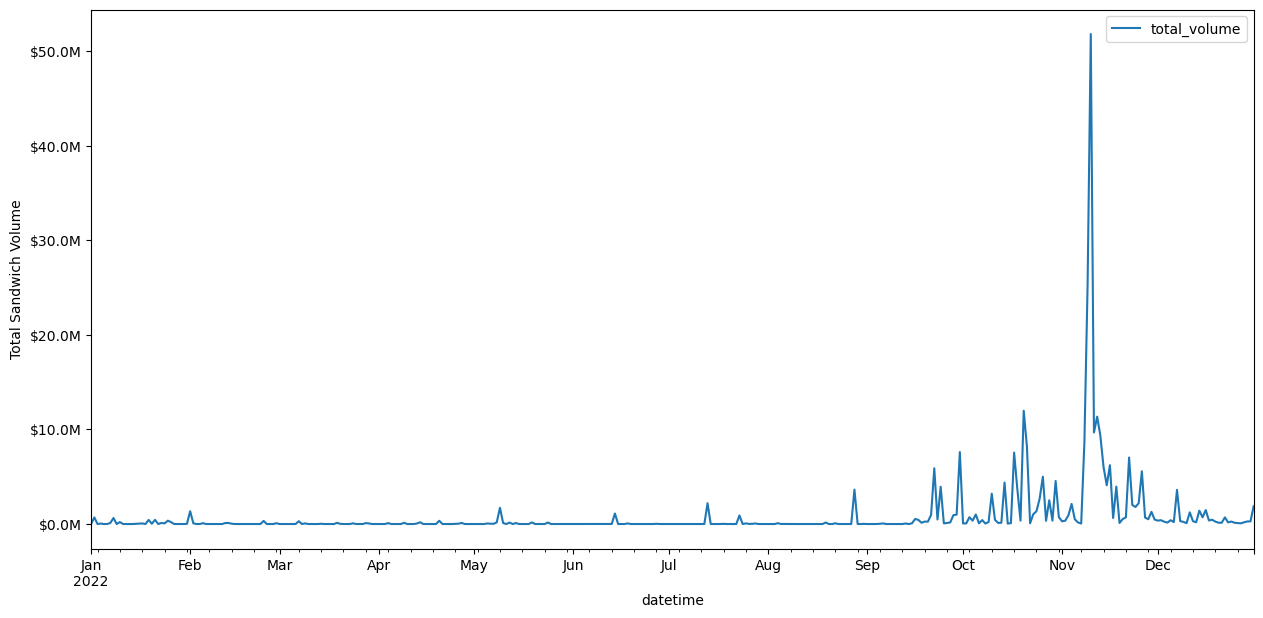

In [212]:
def millions(x, pos):
    return '$%1.1fM' % (x * 1e-6)
fig, ax = plt.subplots(figsize=(15,7))

df_cow_volume[['datetime','total_volume']].groupby('datetime').sum().resample('D').sum().plot(ax=ax)
ax.yaxis.set_major_formatter(plt.FuncFormatter(millions))
ax.set_ylabel('Total Sandwich Volume')

In [213]:
volume_plot_m=df_cow_volume[['datetime','total_volume','A_volume_sum','V_volume']].groupby('datetime').sum().resample('M').sum()

volume_plot_m.index=volume_plot_m.index.strftime('%b')

volume_plot_d=df_cow_volume[['datetime','total_volume','A_volume_sum','V_volume']].groupby('datetime').sum().resample('D').sum()

volume_plot_m=volume_plot_m.rename(columns={'A_volume_sum':'Attacker Volume','V_volume':'Victim Volume'})
volume_plot_d=volume_plot_d.rename(columns={'A_volume_sum':'Attacker Volume','V_volume':'Victim Volume'})

volume_plot_m

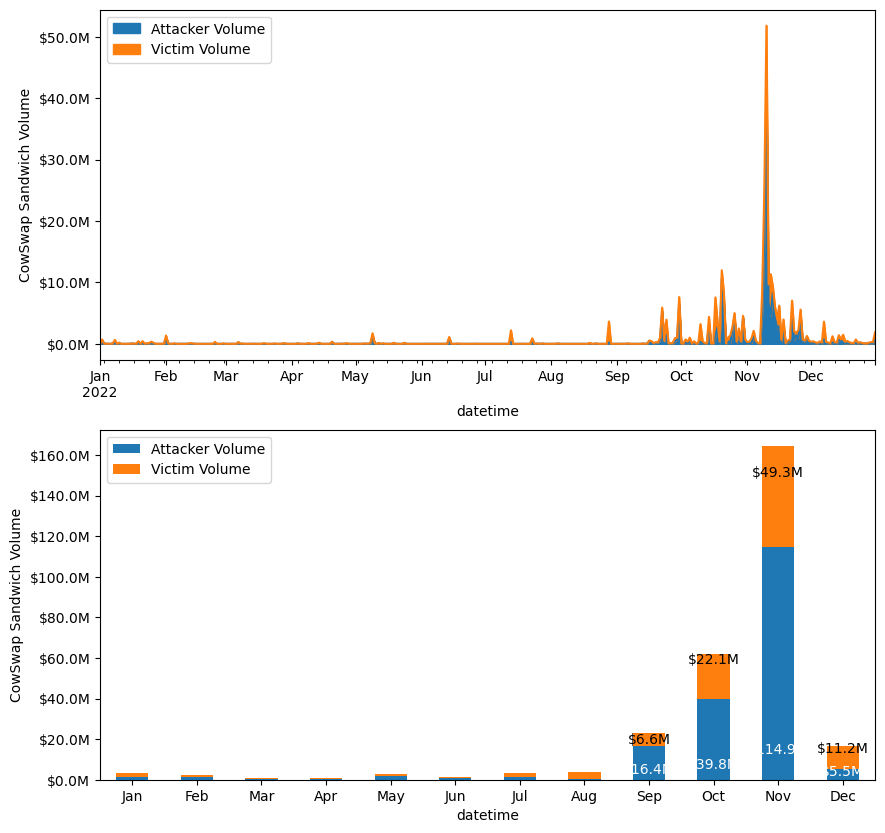

In [218]:
def millions(x, pos):
    return '$%1.1fM' % (x * 1e-6)
fig, axes = plt.subplots(2,1,figsize=(10,10))

volume_plot_d[['Attacker Volume','Victim Volume']].plot.area(stacked=True,ax=axes[0])
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(millions))
axes[0].set_ylabel('CowSwap Sandwich Volume')

volume_plot_m[['Attacker Volume','Victim Volume']].plot(stacked=True,kind='bar',ax=axes[1])
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(millions))
axes[1].set_ylabel('CowSwap Sandwich Volume')
plt.xticks(rotation=0)
for i, v in enumerate(volume_plot_m['Attacker Volume']):
    if i in [8,9,10,11]:
        axes[1].text(i, volume_plot_m['Attacker Volume'][i]*0.1, str('$%1.1fM' % (volume_plot_m['Attacker Volume'][i] * 1e-6)), ha='center', va='bottom',color='white')
        
for i, v in enumerate(volume_plot_m['Victim Volume']):
    if i in [9,10]:
        axes[1].text(i, volume_plot_m['total_volume'][i]*0.9, str('$%1.1fM' % (volume_plot_m['Victim Volume'][i] * 1e-6)), ha='center', va='bottom',color='black')
    elif i in [8,11]:
        axes[1].text(i, volume_plot_m['total_volume'][i]*0.7, str('$%1.1fM' % (volume_plot_m['Victim Volume'][i] * 1e-6)), ha='center', va='bottom',color='black')
plt.show()

(0.0, 1100.0)

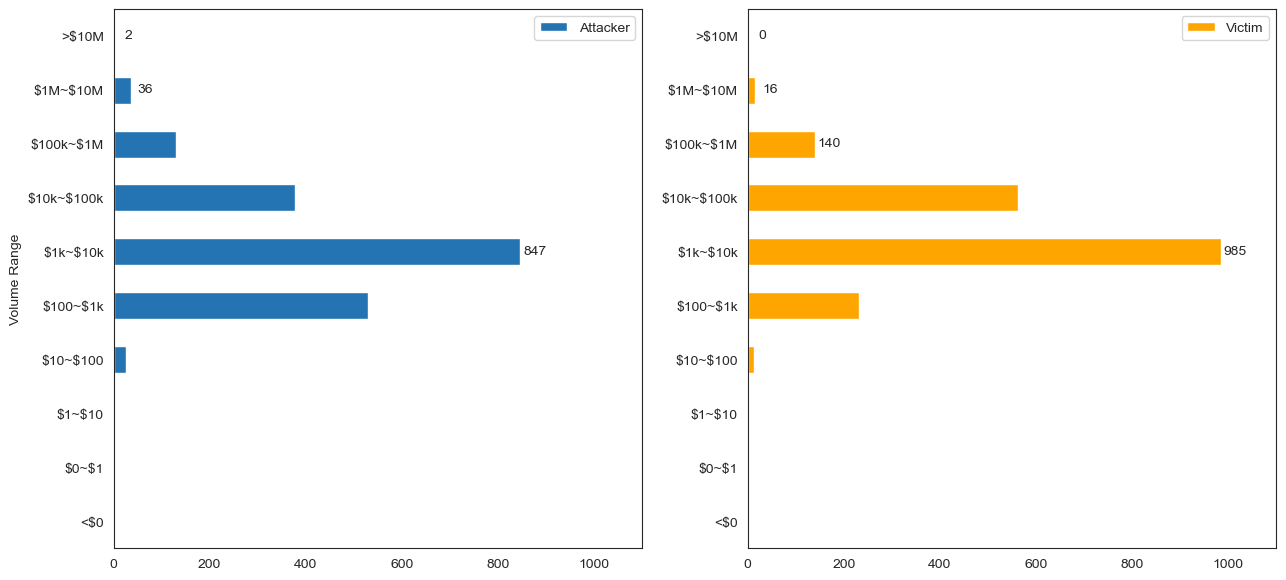

In [219]:
sns.set_style("white") 
bins_custom = [-10*8,0,1, 10, 100, 1000, 10**4,10**5, 10**6, 10**7, 10**8]
bin_point = ['<\$0','\$0~\$1','\$1~\$10','\$10~\$100','\$100~\$1k','\$1k~\$10k','\$10k~\$100k','\$100k~\$1M','\$1M~\$10M','>\$10M']

count1,bin_edges=np.histogram(df_cow_volume['A_volume_sum'], bins=bins_custom, density=False)
count2,bin_edges=np.histogram(df_cow_volume['V_volume'], bins=bins_custom, density=False)
hist=pd.DataFrame([count1,count2]).T.rename(columns={0:'Attacker',1:'Victim'})

hist['bin_point'] = bin_point
hist.set_index('bin_point',inplace=True)

fig, axes =plt.subplots(1,2,figsize=(15,7))
hist['Attacker'].plot.barh(ax=axes[0],color='#2474b4')
for i, v in enumerate(hist['Attacker']):
    if i in [9,8,5]:
        axes[0].text(hist['Attacker'][i]+30, i-0.1, str(hist['Attacker'][i]), ha='center', va='bottom')
    
#plt.yscale('log')
axes[0].set_ylabel('Volume Range')
axes[0].legend(['Attacker'])
axes[0].set_xlim(0,1100)

hist['Victim'].plot.barh(ax=axes[1],color='orange')
for i, v in enumerate(hist['Victim']):
    if i in [9,8,7,5]:
        axes[1].text(hist['Victim'][i]+30, i-0.1, str(hist['Victim'][i]), ha='center', va='bottom')
#plt.yscale('log')
axes[1].set_ylabel('')
axes[1].legend(['Victim'])
axes[1].set_xlim(0,1100)


In [1498]:
df_cow_volume[['A_volume_sum','V_volume','revenue']]

,A_volume_sum,V_volume,revenue
0,11425.687840,1.213575e+03,145.665745
1,526846.969610,1.726508e+05,4449.861130
2,15062.123954,3.355865e+04,1615.204315
3,48341.569027,4.574404e+04,537.606935
4,17928.915718,2.660965e+03,266.981017
...,...,...,...
1948,709.081471,2.580559e+04,5.189532
1949,75261.488427,9.992206e+03,11.490808
1950,109492.802908,9.234082e+03,14.571964
1951,209.514690,4.315672e+02,3.225344


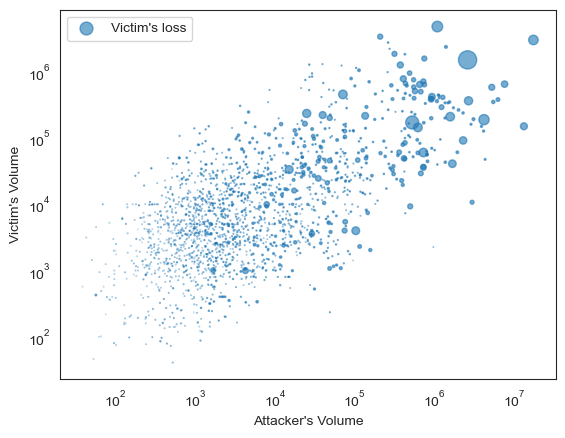

In [220]:
fig, axes =plt.subplots()
axes.scatter(x=df_cow_volume['A_volume_sum'],y=df_cow_volume['V_volume'],s=df_cow_volume['revenue']*2e-2,alpha=0.6)
axes.set_xscale('log')
axes.set_xlabel("Attacker's Volume")
axes.set_yscale('log')
axes.set_ylabel("Victim's Volume")
axes.legend(["Victim's loss"])

In [221]:
#total volume 
#data from Dune
total_batched_value=14622096869.25

In [222]:
def func2(pct):
    absolute = (pct/100.*total_batched_value/1e9)
    return f"{pct:.2f}%\n(${absolute:.2f}B)"

volume_pie_plot=pd.DataFrame({'numbers': [total_batched_value-df_cow_volume['V_volume'].sum(),df_cow_volume['V_volume'].sum()]}, 
             index=['Non-Attacked Batched Volume','Attacked Batched Volume']
            )


volume_pie_plot.plot.pie(y='numbers',autopct=func2)
circle = plt.Circle((0,0), 0.4, color='white')
fig = plt.gcf()
fig.gca().add_artist(circle)
plt.ylabel('')
plt.legend('')

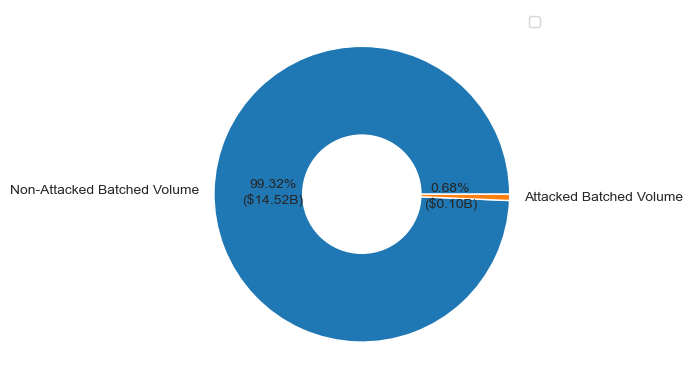

In [225]:
volume_pie_plot.plot.pie(y='numbers',autopct=func2)
circle = plt.Circle((0,0), 0.4, color='white')
fig = plt.gcf()
fig.gca().add_artist(circle)
plt.ylabel('')
plt.legend('')

In [226]:
#solver reward data
#data from Dune
df_solver_reward=pd.read_csv(path+'solver_reward.csv')

In [227]:
df_solver_reward=df_solver_reward[['address', 'cow_reward_prod', 'cow_reward_barn',
       'total_cow_rewarded', 'cow_rewarded_usd']][:47].rename(columns={'address':'Solver'})

df_solver_reward=df_solver_reward.merge(df_solver_info[['Solver','Name','First Eligible Batch','Latest Batch']],on='Solver',how='left')

df_cow_victim['victimEOAs'].loc[1872]='0xb20b86c4e6deeb432a22d773a221898bbbd03036'
df_cow_victim['victimEOAs'].loc[1873]='0xb20b86c4e6deeb432a22d773a221898bbbd03036'

solver_loss=df_cow_victim.groupby(['victimEOAs']).sum()['revenue'].reset_index()
solver_loss=solver_loss.rename(columns={'victimEOAs':'Solver'})
                       

df_solver_reward.merge(solver_loss,on='Solver',how='left')[['Solver','Name','First Eligible Batch',
                                                           'Latest Batch','cow_rewarded_usd','revenue']].fillna(0).to_csv(
path+'solver_loss.csv')

Text(0, 0.5, 'Counts')

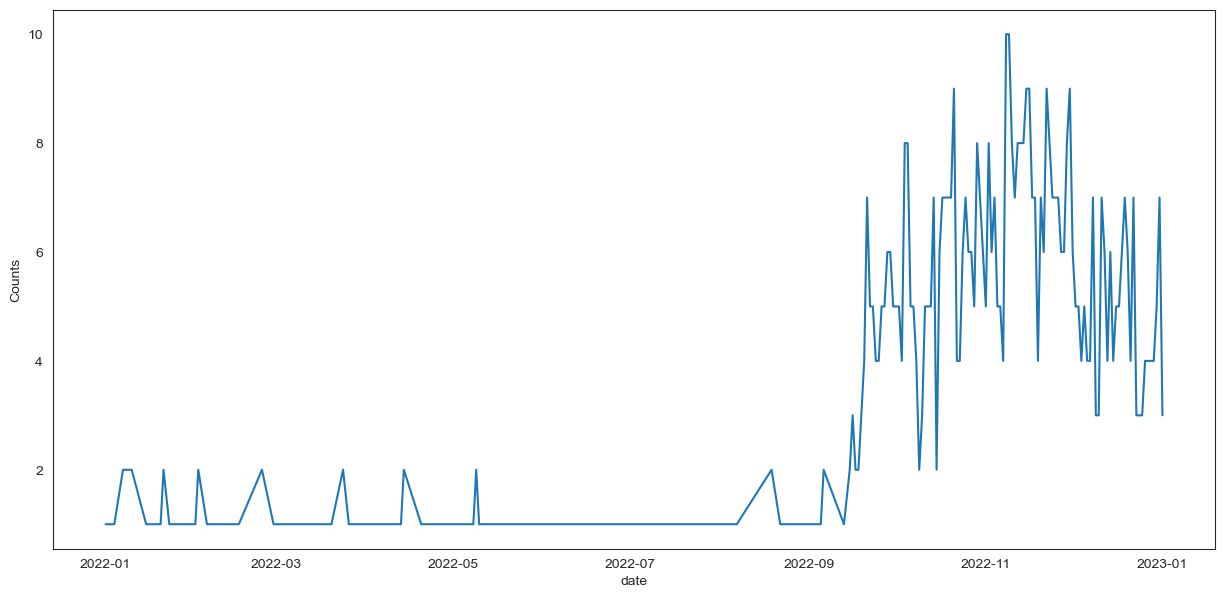

In [235]:
fig, axes =plt.subplots(figsize=(15,7))
df_cow_victim.groupby('date')['victimEOAs'].nunique().plot()
axes.set_ylabel('Counts')

In [236]:
df_cow_volume['victimEOAs'].loc[1705]='0xc9ec550bea1c64d779124b23a26292cc223327b6'
df_cow_volume['victimEOAs'].loc[1872]='0xb20b86c4e6deeb432a22d773a221898bbbd03036'
df_cow_volume['victimEOAs'].loc[1873]='0xb20b86c4e6deeb432a22d773a221898bbbd03036'
df_cow_volume

/var/folders/6b/m6620wh92lnbqjd1dz1tb0n40000gn/T/ipykernel_65751/2417682085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cow_volume['victimEOAs'].loc[1705]='0xc9ec550bea1c64d779124b23a26292cc223327b6'
/var/folders/6b/m6620wh92lnbqjd1dz1tb0n40000gn/T/ipykernel_65751/2417682085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cow_volume['victimEOAs'].loc[1872]='0xb20b86c4e6deeb432a22d773a221898bbbd03036'
/var/folders/6b/m6620wh92lnbqjd1dz1tb0n40000gn/T/ipykernel_65751/2417682085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

,Unnamed: 0,index,blockNumber,blockTimestamp,attackerTxs,attackerTxPositions,victimTxs,victimTxPositions,attackerEOA,attackerContract,...,datetime,date,tokenPriceList,tokenPrices,timestamp.$numberLong,attackerTxslist,A_volume_sum,A_volume_max,V_volume,total_volume
0,0,588,13919324,1641037025,0xdef7c11053ccd015c07936b5feea89dab10ebc342f00...,2 4,0x07e48b8d4bc472e457432f7db25e7292723daa4548aa...,3,0x41d3ab85aafed2ef9e644cb7d3bbca2fc4d8cac8,0x00000000003b3cc22af3ae1eac0440bcee416b40,...,2022-01-01 11:37:05,2022-01-01,"{""timestamp"":{""$numberLong"":""1641037025""},""tok...",[{'address': '0xc02aaa39b223fe8d0a0e5c4f27ead9...,1641037025,[0xdef7c11053ccd015c07936b5feea89dab10ebc342f0...,11425.687840,5785.676702,1.213575e+03,1.263926e+04
1,1,1623,13924042,1641100107,0x2251452b4d8ad630352d790106034b9a84e741698d72...,0 2,0xdda87ae086faa0d8f3f6a7135692d217fc711ce80ef1...,1,0xb3b6dceeb3b6501ac72feb06f36b0446facf38b4,0x7cf09d7a9a74f746edcb06949b9d64bcd9d1604f,...,2022-01-02 05:08:27,2022-01-02,"{""timestamp"":{""$numberLong"":""1641100107""},""tok...",[{'address': '0x4e3fbd56cd56c3e72c1403e103b45d...,1641100107,[0x2251452b4d8ad630352d790106034b9a84e741698d7...,526846.969610,265648.415370,1.726508e+05,6.994978e+05
2,2,4503,13937319,1641276929,0x40ebc92ca462b08c9279f13cb8802169e6da5740471c...,0 2,0x200772c408e9282b785ae8dbfe19ba2547b6ff4749af...,1,0x26ce7c1976c5eec83ea6ac22d83cb341b08850af,0x00000000003b3cc22af3ae1eac0440bcee416b40,...,2022-01-04 06:15:29,2022-01-04,"{""timestamp"":{""$numberLong"":""1641276929""},""tok...",[{'address': '0xc02aaa39b223fe8d0a0e5c4f27ead9...,1641276929,[0x40ebc92ca462b08c9279f13cb8802169e6da5740471...,15062.123954,8338.664175,3.355865e+04,4.862078e+04
3,3,8661,13956009,1641527647,0x7dd255175c26526b60a603a2754efbc0faeaee4fc86b...,3 5,0x00c2b835f25a1ac67fba377c987f308a1235ae9c2645...,4,0xb3b6dceeb3b6501ac72feb06f36b0446facf38b4,0x7cf09d7a9a74f746edcb06949b9d64bcd9d1604f,...,2022-01-07 03:54:07,2022-01-07,"{""timestamp"":{""$numberLong"":""1641527647""},""tok...",[{'address': '0xc02aaa39b223fe8d0a0e5c4f27ead9...,1641527647,[0x7dd255175c26526b60a603a2754efbc0faeaee4fc86...,48341.569027,25413.065849,4.574404e+04,9.408561e+04
4,4,8737,13956225,1641530631,0x966f35f58dc80f37e7d421cdfffeb7456becc9f7ed43...,1 3,0xe55772ae67f4333107180dd204e9d9b6e218f133a833...,2,0x7aa0426f10c7603bbfb8ceb8afb8d8c329ccfe8b,0x000000000035b5e5ad9019092c665357240f594e,...,2022-01-07 04:43:51,2022-01-07,"{""timestamp"":{""$numberLong"":""1641530631""},""tok...",[{'address': '0xc02aaa39b223fe8d0a0e5c4f27ead9...,1641530631,[0x966f35f58dc80f37e7d421cdfffeb7456becc9f7ed4...,17928.915718,9097.948367,2.660965e+03,2.058988e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,1948,597446,16307256,1672519967,0x8916a4ec084895834a313b196f5d306d1834264500b7...,7 114,0xcba8c09febb5dd185554edd58dbe59e002ed6a174c95...,113,0xc6a3739695f0b65733261219128f96a7b8789994,0x1111111254eeb25477b68fb85ed929f73a960582,...,2022-12-31 20:52:47,2022-12-31,"{""timestamp"":{""$numberLong"":""1672519967""},""tok...",[{'address': '0x29127fe04ffa4c32acac0ffe17280a...,1672519967,[0x8916a4ec084895834a313b196f5d306d1834264500b...,709.081471,357.049008,2.491857e+04,2.562765e+04
1948,1949,597509,16307331,1672520867,0xc5c043b456726db4d793fbac0eab53c15c1784771c0d...,2 4,0x32e7b20d74c4b18d9766704da90a9a5557d749dd4b33...,3,0x3eadde4a48d0aebda37eed7076e736edac9a8b40,0x0000000099cb7fc48a935bceb9f05bbae54e8987,...,2022-12-31 21:07:47,2022-12-31,"{""timestamp"":{""$numberLong"":""1672520867""},""tok...",[{'address': '0xa0b86991c6218b36c1d19d4a2e9eb0...,1672520867,[0xc5c043b456726db4d793fbac0eab53c15c1784771c0...,75261.488427,37636.489618,9.975535e+03,8.523702e+04
1949,1950,597513,16307332,1672520879,0x946fffbd2aa14f3816f5df46a30013c24bbf60bff823...,5 7,0xa8f041bd473fe85822b78d0ed46524a075e93e792716...,6,0x4970197593ef5aed9d2c33409b953f5f9bb22563,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,...,2022-12-31 21:07:59,2022-12-31,"{""timestamp"":{""$num

In [237]:
solvers_ranking=df_cow_volume.groupby('victimEOAs').agg({'victimTxs':'count','V_volume':'sum'}).sort_values('victimTxs').reset_index()

solvers_ranking=solvers_ranking.merge(df_solver_info[['Solver','Name']],left_on='victimEOAs',right_on='Solver',how='left')

solvers_ranking['short_name']=solvers_ranking['Name']+'_'+solvers_ranking['victimEOAs'].apply(lambda x: x[:6])


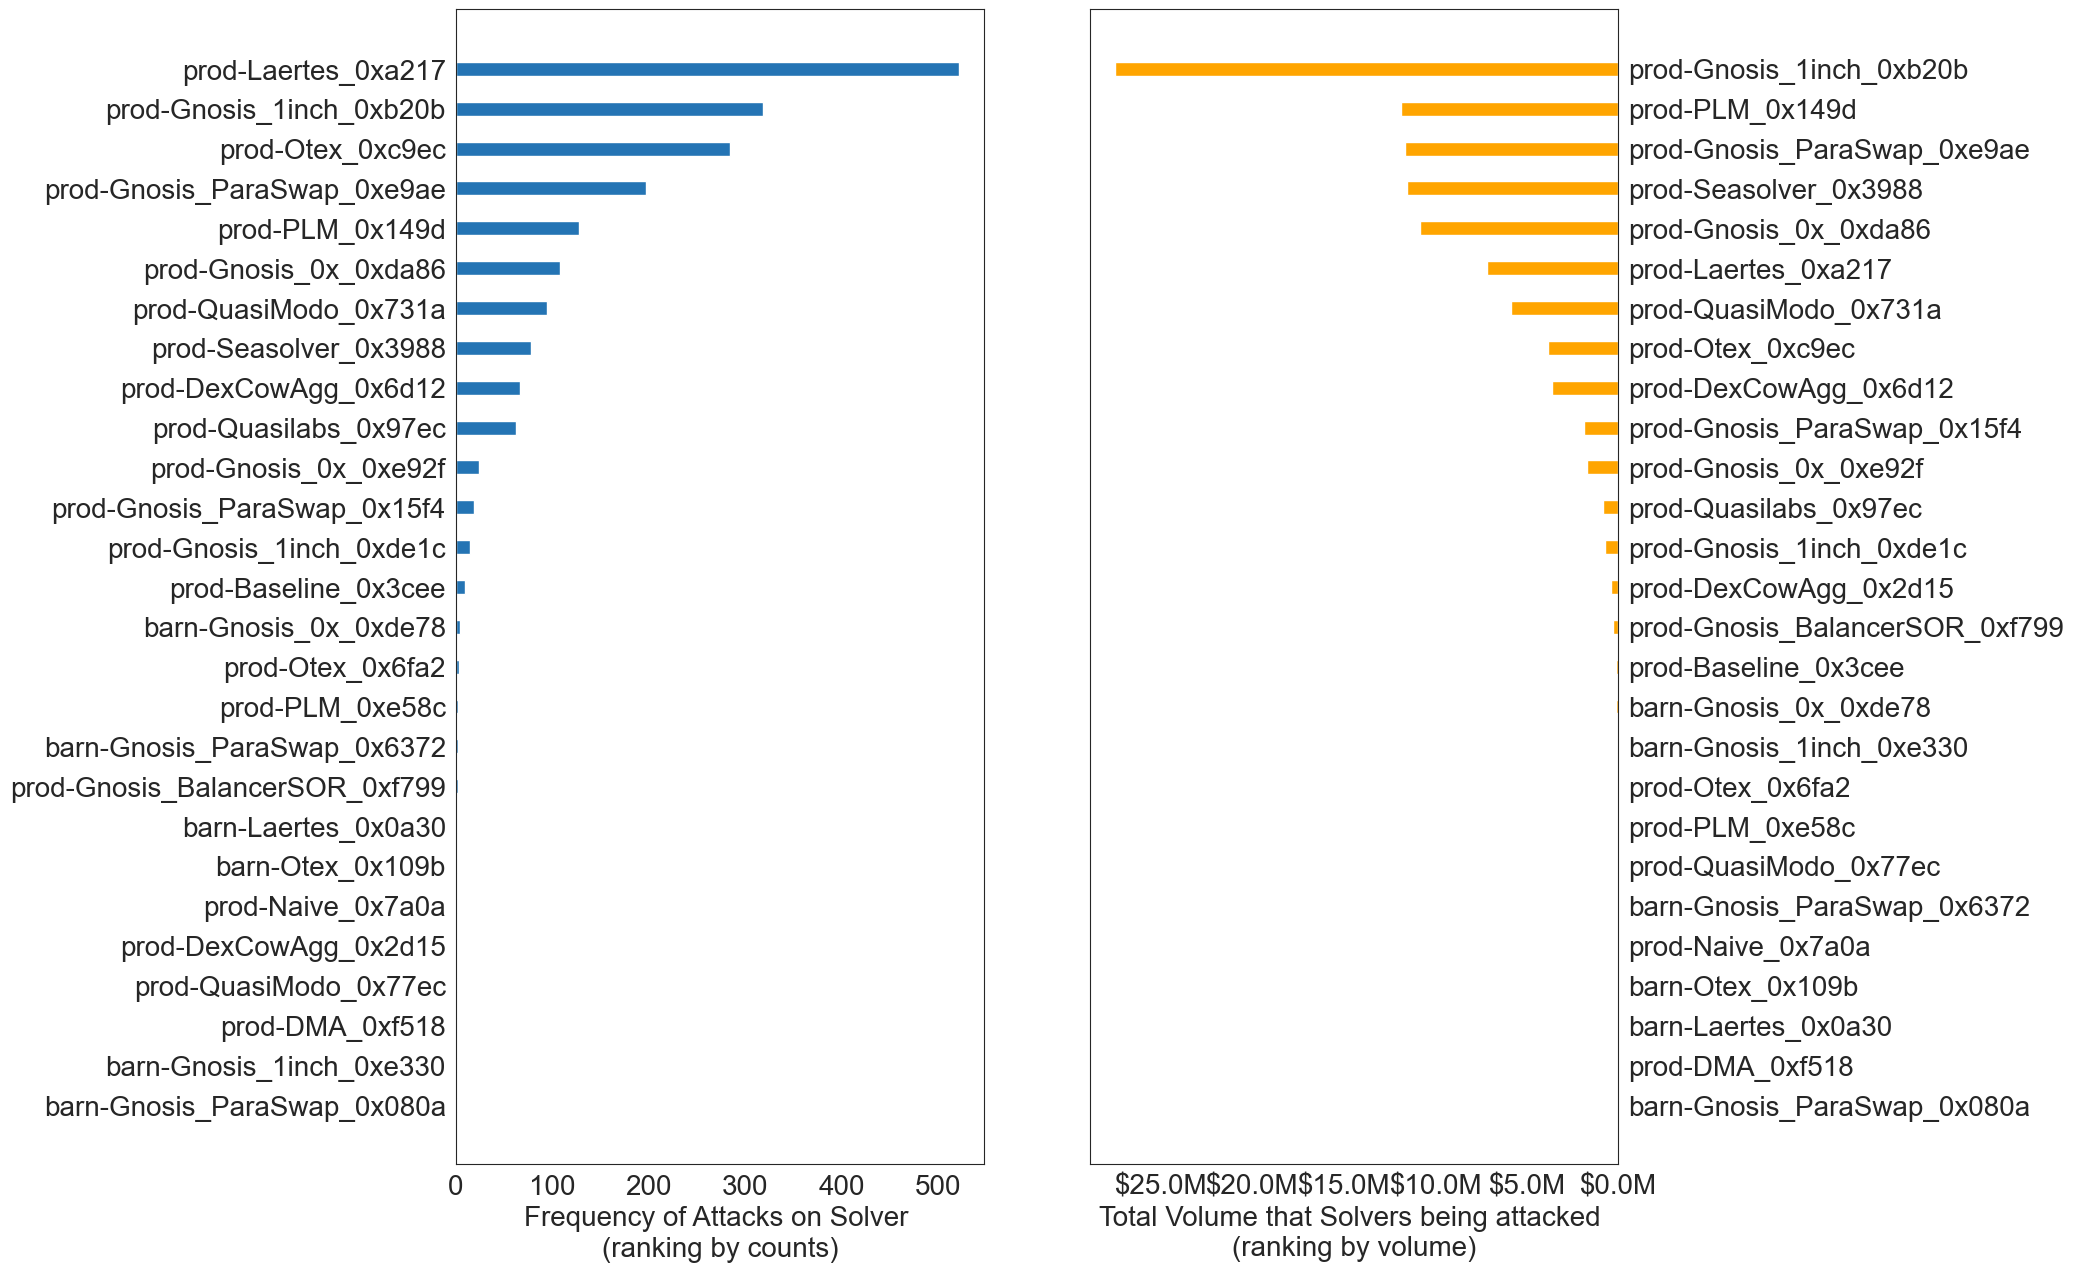

In [241]:
fig, axes = plt.subplots(1,2,figsize=(15,15))
def millions(x, pos):
    return '$%1.1fM' % (x * 1e-6)
bars1=axes[0].barh(solvers_ranking['short_name'],solvers_ranking['victimTxs'],
         height=0.35,color='#2474b4')
axes[0].tick_params(labelsize=20)
axes[0].set_xlabel('Frequency of Attacks on Solver \n(ranking by counts)',size=20)
#ax1.set_title('Most Active Solver')
#for i, bar in enumerate(bars1):
    #axes[0].text(1, i+0.5, str(solvers_ranking['short_name'][i]), ha='left', va='center')

#ax1.set_xlim(0,5000)
bars=axes[1].barh(solvers_ranking.sort_values('V_volume')['short_name'],solvers_ranking.sort_values('V_volume')['V_volume'],
         height=0.35,color='orange')
axes[1].invert_xaxis()
#axes[1].set_yticklabels([])
axes[1].tick_params(axis='y', labelright=True, labelleft=False,labelsize=20)
axes[1].tick_params(axis='x', labelsize=20)
axes[1].set_xlabel('Total Volume that Solvers being attacked \n(ranking by volume)',size=20)
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(millions))
#for i, v in enumerate(bars2):
    #ax2.text(plot_top10_solver_total['Trades'][i]+10, i+0.1, str("{:.3f}".format(plot_top10_solver_total['attackedPct'][i] * 100))+'%', ha='center', va='bottom',color='green')
 

In [242]:
df_solver_reward=df_solver_reward.merge(solver_loss,on='Solver',how='left')[['Solver','Name','First Eligible Batch',
                                                           'Latest Batch','cow_rewarded_usd','revenue']].fillna(0)

df_solver_info.merge(df_solver_reward[df_solver_reward['revenue']==0]['Solver'],on='Solver',how='inner')

In [1756]:
df_solver_info[df_solver_reward[df_solver_reward['revenue']==0]['Solver']

18    0x833f076d182123ca8dde2743045ea02957bd61ef
19    0xe8ff24ec26bd46e0140d1824da44efad2a0920b5
20    0xf2d21ad3c88170d4ae52bbbeba80cb6078d276f4
22    0xbff9a1b539516f9e20c7b621163e676949959a66
23    0xe18b5632df2ec339228dd65e4d9f004ef59653d3
24    0xda324c2f06d3544e7965767ce9ca536dcb67a660
26    0xdae69affe582d36f330ee1145995a53fab670962
29    0xa0044c620da7f2876da7004719b8370eb7be5e50
30    0xa97def4fbcba3b646dd169bc2eee40f0f3fe7771
32    0x5b0bfe439ab45a4f002c259b1654ed21c9a42d69
33    0x340185114f9d2617dc4c16088d0375d09fee9186
34    0x55a37a2e5e5973510ac9d9c723aec213fa161919
35    0x0d2584da2f637805071f184bcfa1268ebae8a24a
38    0x8a4e90e9afc809a69d2a3bdbe5fff17a12979609
39    0x22dee0935c77d32c7241362b14e76fc2d5ef657d
40    0x8567351d6989d83513d3bc3ad951ccce363941e3
41    0x8ccc61dba297833dbe5d95fd6360f106b9a7576e
42    0xffc5e9d86c0e069f8b037c841acc72cf94eebad8
43    0x1857afb4da9bd4cc1c6e5287ad41cb5be469f14e
44    0x872a1b63a739190d0780721d57d8d92ef766db35
45    0x5b2f5e5c94a5